## Final Project Submission

Please fill out:
* Student name: Rachel Beery
* Student pace: Full time
* Scheduled project review date/time: 9/21/2020 5:00 P.M.
* Instructor name: James
* Blog post URL:https://rachelbeery.github.io/module_2_blog


# Module 2 Final Project: King County Housing Authority 

**Objective:** In this project we will be finding the best model for interpretability so that our non-technical audience can understand the findings of our modeling. 

**Approach:** The OSEUMiN data science workflow is utilized to effectively create a model to find what factors can result in the most profitable house. We will be focusing solely on features of the home that the homeowner can control.

**Data:** The data used for this project was records of houses sold in King County Washington. The columns of data provided include:

* **id** - unique identifier for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zip code** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

**Audience:** Non-technical audience of homeowners within King County, Washington who are interested to know what they can do to improve their home to maximize the selling price of their homes.

Questions we will be answering in this notebook:

1. What outlier removal method is the most effective?

2. What effect does outliers have on our outcomes and overall data?

3. How will multicollinearity affect what feature yields the highest selling price?

4. What features of a house yield make the house sell at a higher price?

# Importing Packages & Our Data

In [1]:
#We begin by importing all the packages we will need to read and clean the datasets, analyze the data, and finally make visualizations 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
import plotly.express as px
import math
import scipy.stats as stats
import missingno as ms

from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
linreg = LinearRegression()

In [2]:
# Setting the display defaults
pd.set_option('display.max_columns', 0)
# pd.set_option('display.max_rows',)

# Turning off scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
#Import data and see the headers
house_data = pd.read_csv(r"kc_house_data.csv")
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.000,3,1.000,1180,5650,1.000,nan,0.000,3,7,1180,0.0,1955,0.000,98178,47.511,-122.257,1340,5650
1,6414100192,12/9/2014,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,3,7,2170,400.0,1951,1991.000,98125,47.721,-122.319,1690,7639
2,5631500400,2/25/2015,180000.000,2,1.000,770,10000,1.000,0.000,0.000,3,6,770,0.0,1933,nan,98028,47.738,-122.233,2720,8062
3,2487200875,12/9/2014,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,5,7,1050,910.0,1965,0.000,98136,47.521,-122.393,1360,5000
4,1954400510,2/18/2015,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,3,8,1680,0.0,1987,0.000,98074,47.617,-122.045,1800,7503


In [4]:
# How many houses are in our dataset
house_data.shape

(21597, 21)

In [5]:
# Looking at our columns and seeing what data types they are
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


# Scrub

First I want to drop the columns/features that the home owner cannot change about their home. This will help in focusing on exploring and cleaning the data that I am interested in.

In [6]:
house_data = house_data.drop(columns=['id', 'waterfront', 'view', 'zipcode', 
                                      'lat', 'long', 'sqft_lot', 'yr_built', 'sqft_lot15', 
                                        'sqft_living15'])

In [7]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
floors           21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_renovated     17755 non-null float64
dtypes: float64(4), int64(5), object(2)
memory usage: 1.8+ MB


In [8]:
# Changing dtypes that we know are numbers
house_data.price.astype('int64')

0        221900
1        538000
2        180000
3        604000
4        510000
          ...  
21592    360000
21593    400000
21594    402101
21595    400000
21596    325000
Name: price, Length: 21597, dtype: int64

In [9]:
house_data.price.describe()

count     21597.000
mean     540296.574
std      367368.140
min       78000.000
25%      322000.000
50%      450000.000
75%      645000.000
max     7700000.000
Name: price, dtype: float64

In [10]:
# Looking at all the object columns and seeing the unique values in each
objects = house_data.select_dtypes(include='object')
house_data.nunique()

date              372
price            3622
bedrooms           12
bathrooms          29
sqft_living      1034
floors              6
condition           5
grade              11
sqft_above        942
sqft_basement     304
yr_renovated       70
dtype: int64

In [11]:
# Finding out where null values are in DF
nulls = house_data.isna().sum()
only_nulls = nulls[nulls>0]/len(house_data)
only_nulls.to_frame('Percent Null').style.background_gradient(cmap='Reds')
# Yr_renovated is the only one

,Percent Null
yr_renovated,0.177895


In [12]:
null_cols = list(only_nulls.index)
null_cols

['yr_renovated']

In [13]:
house_data[null_cols].mode()

,yr_renovated
0,0.000


In [14]:
house_data[null_cols].nunique()

yr_renovated    70
dtype: int64

In [15]:
house_data.isna().sum(axis=1).value_counts()

0    17755
1     3842
dtype: int64

In [16]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


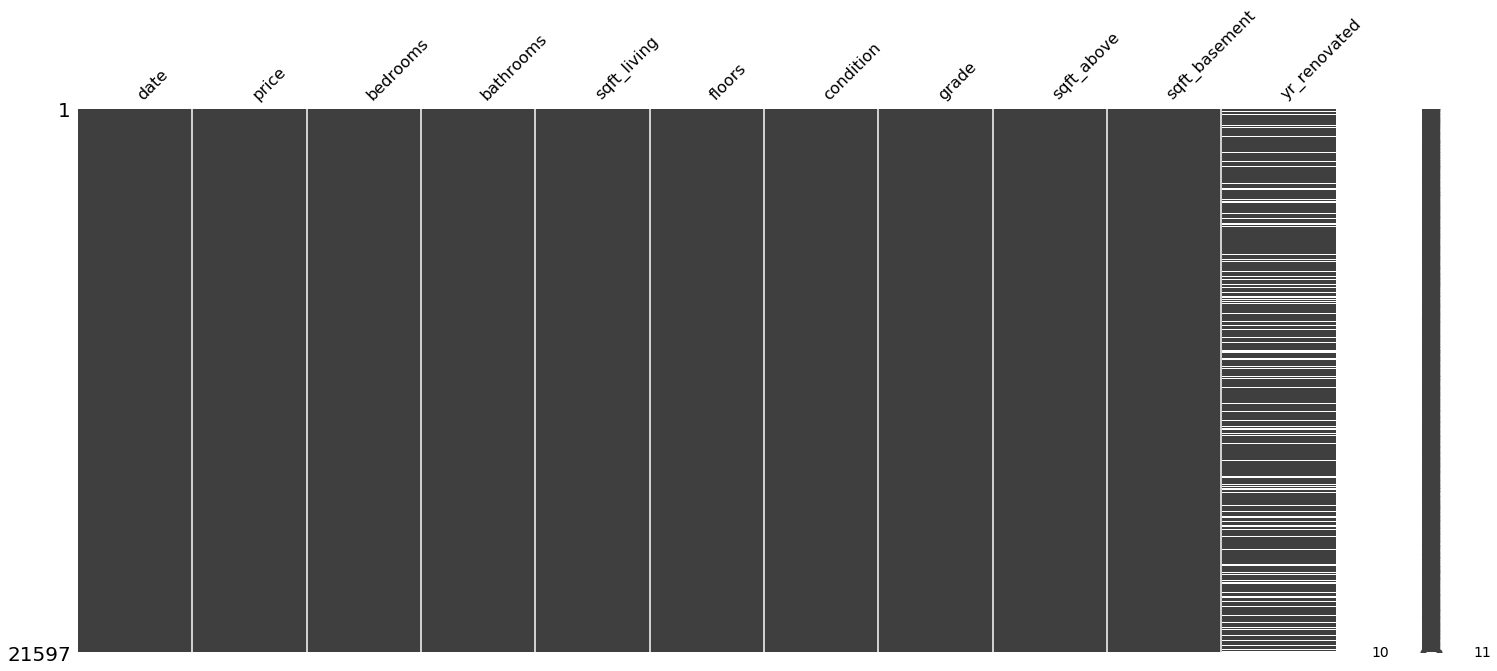

In [17]:
# Seeing if there is a pattern in specific houses that having nulls
import missingno as ms
ms.matrix(house_data)

In [18]:
# What columns have null values
house_data.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
floors              0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_renovated     3842
dtype: int64

In [19]:
# Fix sqft of basement first
house_data['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1284.0        1
792.0         1
556.0         1
3000.0        1
65.0          1
Name: sqft_basement, Length: 304, dtype: int64

In [20]:
# Fixing the '?'
house_data['sqft_basement'].replace('?', np.nan, inplace = True) 
# Changing the dtype to float instead of string
house_data['sqft_basement'] = house_data['sqft_basement'].astype('float')

In [21]:
house_data['sqft_basement'].replace('?', '0')

0         0.000
1       400.000
2         0.000
3       910.000
4         0.000
          ...  
21592     0.000
21593     0.000
21594     0.000
21595     0.000
21596     0.000
Name: sqft_basement, Length: 21597, dtype: float64

In [22]:
# Nulls will be changed to the mode of 0.0 for basement sqft 
house_data['sqft_basement'].mode()
house_data['sqft_basement'].fillna(0.0, axis = 0, inplace=True)

In [23]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
floors           21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_renovated     17755 non-null float64
dtypes: float64(5), int64(5), object(1)
memory usage: 1.8+ MB


In [24]:
# Changing 'sqft_basement' to int64
house_data['sqft_basement'].astype('int64')

0          0
1        400
2          0
3        910
4          0
        ... 
21592      0
21593      0
21594      0
21595      0
21596      0
Name: sqft_basement, Length: 21597, dtype: int64

In [25]:
house_data['date'].value_counts()

6/23/2014     142
6/25/2014     131
6/26/2014     131
7/8/2014      127
4/27/2015     126
             ... 
11/30/2014      1
3/8/2015        1
8/3/2014        1
11/2/2014       1
1/17/2015       1
Name: date, Length: 372, dtype: int64

In [26]:
# Changing the date column into a datetime
house_data['date'] = pd.to_datetime(house_data['date'])
# Making a new column for year
house_data['year'] = house_data['date'].dt.year
# Making a new column for month
house_data['month'] = house_data['date'].dt.month 
# Making a new column for day
house_data['day'] = house_data['date'].dt.dayofweek

In [27]:
house_data = house_data.drop(['date', 'year', 'day'], axis = 1)

In [28]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
floors           21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_renovated     17755 non-null float64
month            21597 non-null int64
dtypes: float64(5), int64(6)
memory usage: 1.8 MB


In [29]:
# Removing null values and changing the data type to integer
house_data['yr_renovated'].mode()
house_data['yr_renovated'].fillna(0.0, axis = 0, inplace = True)
house_data['yr_renovated'] = house_data['yr_renovated'].astype('int')
house_data['yr_renovated'].value_counts()

0       20853
2014       73
2003       31
2013       31
2007       30
        ...  
1976        1
1953        1
1951        1
1946        1
1944        1
Name: yr_renovated, Length: 70, dtype: int64

In [30]:
# There are many houses that dont have renovation
# Will make these Booleans with this function below

for i in house_data['yr_renovated']:
    if i > 0:
        house_data['yr_renovated'].replace(i, 1, inplace = True)

# Change column name
house_data['was_renovated'] = house_data['yr_renovated']
house_data.drop(['yr_renovated'], axis = 1, inplace = True)

print(house_data['was_renovated'].value_counts())
house_data.head()

0    20853
1      744
Name: was_renovated, dtype: int64


,price,bedrooms,bathrooms,sqft_living,floors,condition,grade,sqft_above,sqft_basement,month,was_renovated
0,221900.000,3,1.000,1180,1.000,3,7,1180,0.000,10,0
1,538000.000,3,2.250,2570,2.000,3,7,2170,400.000,12,1
2,180000.000,2,1.000,770,1.000,3,6,770,0.000,2,0
3,604000.000,4,3.000,1960,1.000,5,7,1050,910.000,12,0
4,510000.000,3,2.000,1680,1.000,3,8,1680,0.000,2,0


In [31]:
# Is there anymore we need to fix before outlier removal?
house_data.head()
house_data.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
floors           0
condition        0
grade            0
sqft_above       0
sqft_basement    0
month            0
was_renovated    0
dtype: int64

In [32]:
house_data.month.value_counts()

5     2414
4     2229
7     2211
6     2178
8     1939
10    1876
3     1875
9     1771
12    1470
11    1409
2     1247
1      978
Name: month, dtype: int64

In [33]:
# Making seasons to see what time of year might have the highest selling points
def seasons(x):
    if x > 0 and x < 4:
        season = 1
    elif x > 3 and x < 7:
        season = 2
    elif x > 6 and x < 10:
        season = 3
    else:
        season = 4       
    return season

In [34]:
house_data['seasons'] = house_data['month'].map(seasons)

In [35]:
house_data.seasons.value_counts()
### Need to change so that it's categorical
# The best = Season 2
# The worst = Season 1

2    6821
3    5921
4    4755
1    4100
Name: seasons, dtype: int64

In [36]:
house_data['has_basement'] = house_data['sqft_basement'].map(lambda x: x!=0 )

In [37]:
house_data['has_basement'] = house_data['has_basement'].astype('int64')

In [38]:
house_data.has_basement.value_counts()

0    13280
1     8317
Name: has_basement, dtype: int64

In [39]:
house_data = house_data.drop(columns=['sqft_basement'])

# Exploring

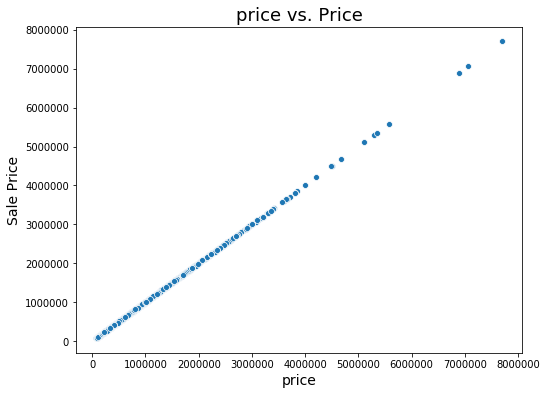

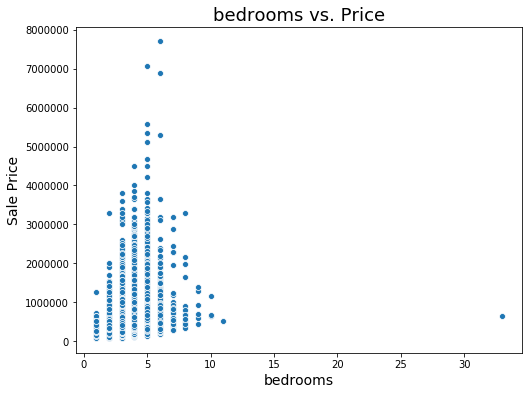

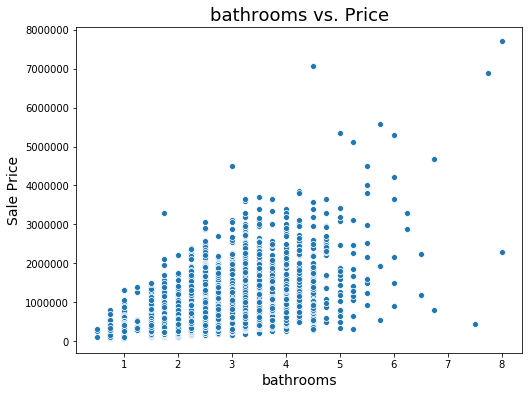

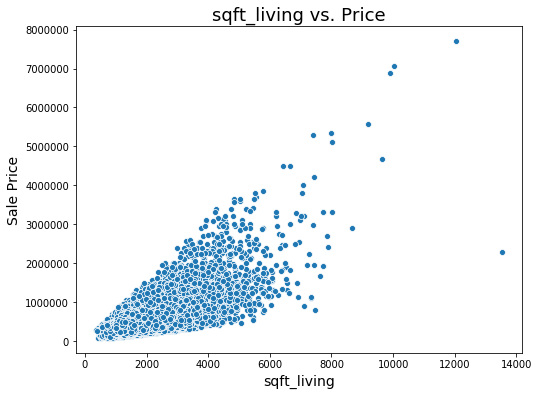

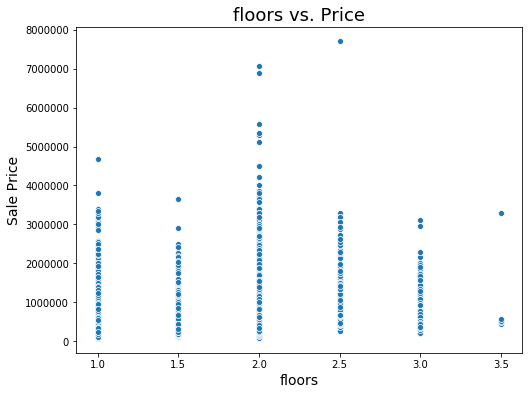

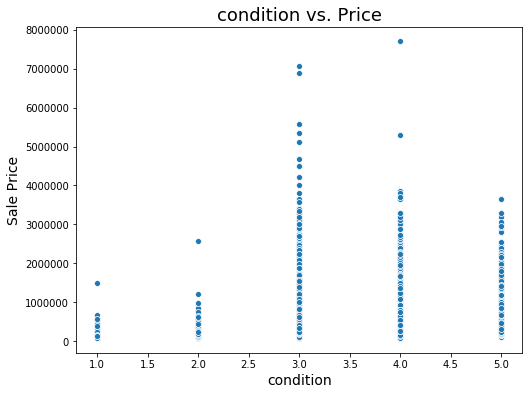

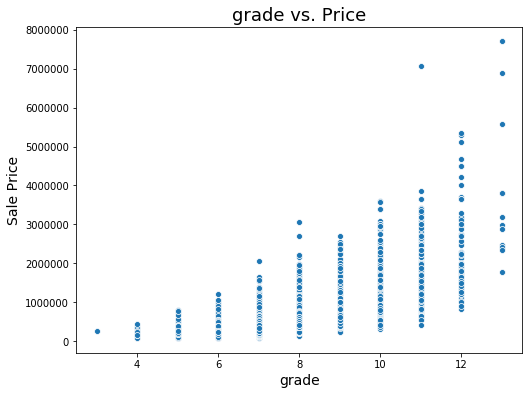

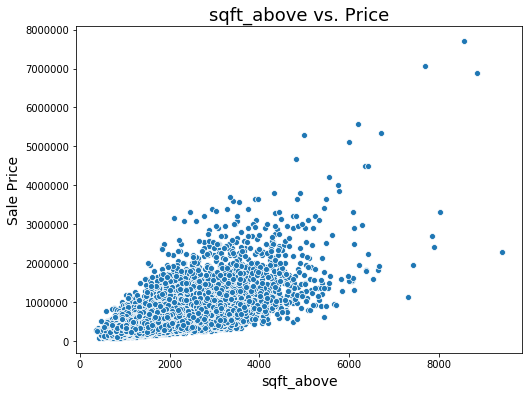

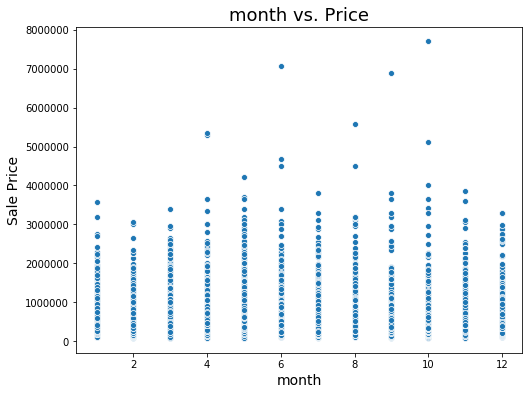

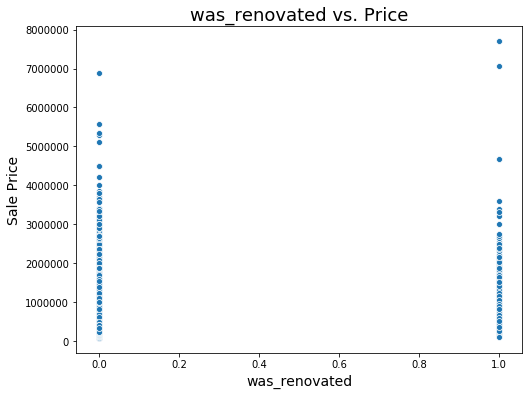

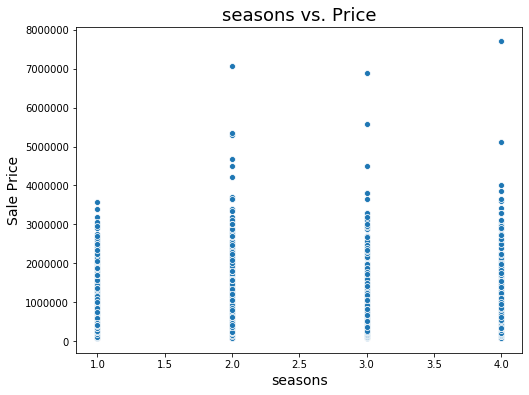

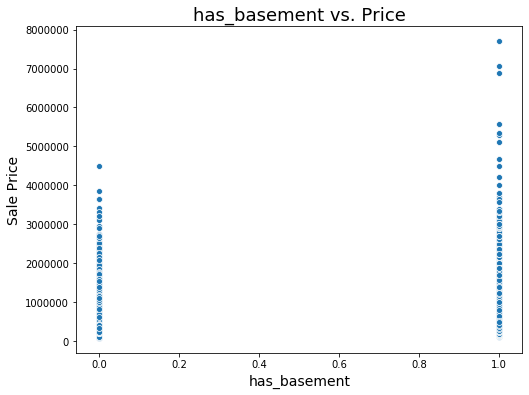

In [40]:
# A good method to understand the spread of each variable is through plotting

# Creating a function to make scatter plots
def scatterplot(col):
    ax = plt.figure(figsize = (8,6))
    ax = sns.scatterplot(x = house_data[col], y = house_data['price'])
    ax.set_title('{} vs. Price'.format(col), fontsize = 18)
    ax.set_xlabel('{}'.format(col), fontsize = 14)
    ax.set_ylabel('Sale Price', fontsize = 14);

for col in house_data:

    scatterplot(col)

In [41]:
# Defining the features that might work better as categories
house_data['condition'] = house_data['condition'].astype('object')
house_data['seasons'] = house_data['seasons'].astype('object')
house_data['month'] = house_data['month'].astype('object')

In [42]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 12 columns):
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
floors           21597 non-null float64
condition        21597 non-null object
grade            21597 non-null int64
sqft_above       21597 non-null int64
month            21597 non-null object
was_renovated    21597 non-null int32
seasons          21597 non-null object
has_basement     21597 non-null int64
dtypes: float64(3), int32(1), int64(5), object(3)
memory usage: 1.9+ MB


In [43]:
pd.get_dummies(house_data)

,price,bedrooms,bathrooms,sqft_living,floors,grade,sqft_above,was_renovated,has_basement,condition_1,condition_2,condition_3,condition_4,condition_5,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,seasons_1,seasons_2,seasons_3,seasons_4
0,221900.000,3,1.000,1180,1.000,7,1180,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,538000.000,3,2.250,2570,2.000,7,2170,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,180000.000,2,1.000,770,1.000,6,770,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,604000.000,4,3.000,1960,1.000,7,1050,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,510000.000,3,2.000,1680,1.000,8,1680,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.000,3,2.500,1530,3.000,8,1530,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
21593,400000.000,4,2.500,2310,2.000,8,2310,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
21594,402101.000,2,0.750,1020,2.000,7,1020,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
21595,400000.000,3,2.500,1600,2.000,8,1600,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [44]:
# Plotting Price with the categories:
def categorical_plots(df):
    for col in df.select_dtypes('object'):
        fig, ax = plt.subplots(figsize=(10,6))
        sns.barplot(x=col, y='price', data=df, palette="colorblind")
        ax.set_title(f"{col} vs Price", fontsize=30)
        plt.xticks(rotation=45)
        plt.show()

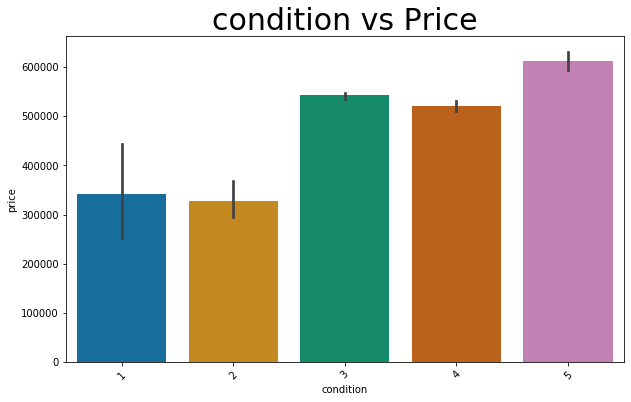

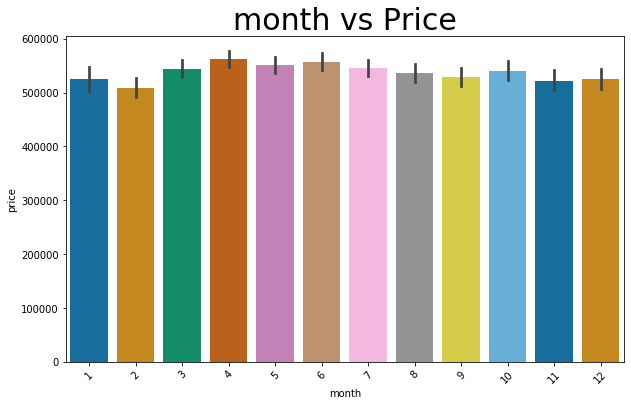

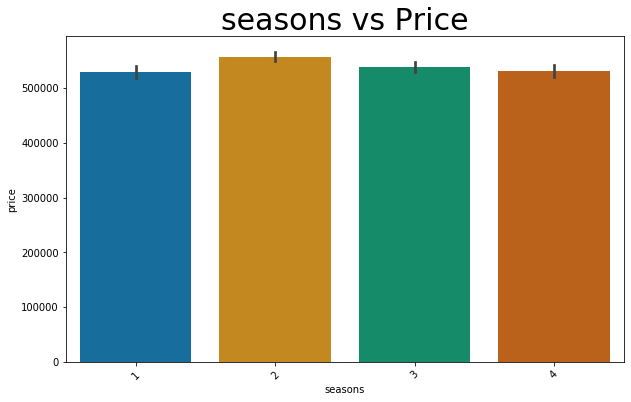

In [45]:
categorical_plots(house_data)

### Multicolinearity

In [46]:
# We will be dropping zipcode, lat, and long from this model as they have to do with location
# which the homeowner cannot change
df1 = house_data.copy()
df1.head()

,price,bedrooms,bathrooms,sqft_living,floors,condition,grade,sqft_above,month,was_renovated,seasons,has_basement
0,221900.000,3,1.000,1180,1.000,3,7,1180,10,0,4,0
1,538000.000,3,2.250,2570,2.000,3,7,2170,12,1,4,1
2,180000.000,2,1.000,770,1.000,3,6,770,2,0,1,0
3,604000.000,4,3.000,1960,1.000,5,7,1050,12,0,4,1
4,510000.000,3,2.000,1680,1.000,3,8,1680,2,0,1,0


In [47]:
# Checking for correlation in features before we go to remove outliers
corr1 = df1.iloc[:,2:] 
corr1.corr().abs().style.background_gradient(cmap='coolwarm')

,bathrooms,sqft_living,floors,grade,sqft_above,was_renovated,has_basement
bathrooms,1,0.755758,0.502582,0.665838,0.686668,0.0467422,0.159863
sqft_living,0.755758,1,0.353953,0.762779,0.876448,0.0508293,0.201198
floors,0.502582,0.353953,1,0.458794,0.523989,0.00371281,0.252465
grade,0.665838,0.762779,0.458794,1,0.756073,0.0152589,0.0507011
sqft_above,0.686668,0.876448,0.523989,0.756073,1,0.0205655,0.207268
was_renovated,0.0467422,0.0508293,0.00371281,0.0152589,0.0205655,1,0.0445999
has_basement,0.159863,0.201198,0.252465,0.0507011,0.207268,0.0445999,1


(9, -0.5)

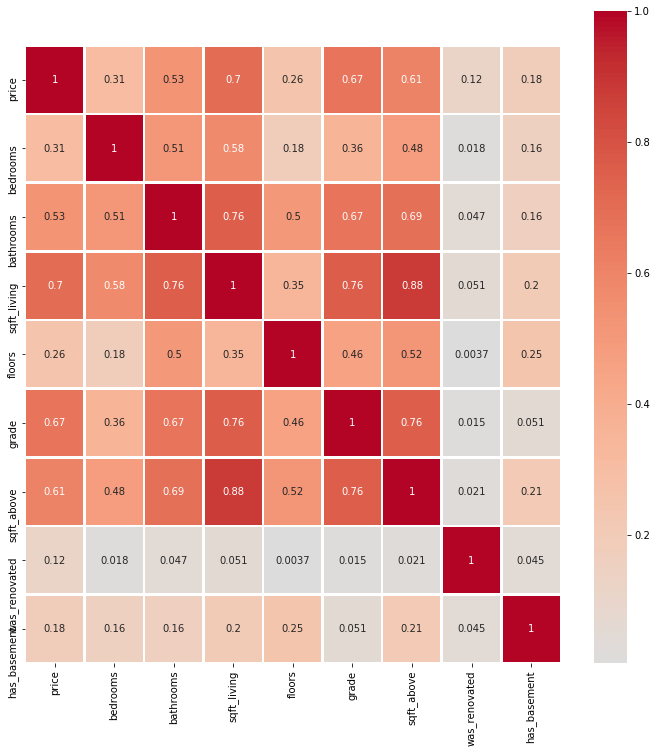

In [48]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df1.corr().abs(), center=0, annot=True, linewidths=1.5, cmap='coolwarm');
ax.set_ylim(len(df1.corr())-0, -0.5)

**To note:
There are some features that have high correlation that will need to be addressed later on**
    

### Modeling before Addressing Outliers

In [49]:
features = '+'.join(house_data.drop('price', axis = 1).columns)
formula = 'price ~' + features
model1 = smf.ols(formula, house_data).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     1256.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        17:22:53   Log-Likelihood:            -2.9821e+05
No. Observations:               21597   AIC:                         5.965e+05
Df Residuals:                   21573   BIC:                         5.967e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -4.751e+05   4.68e+04    -10.148      0.000   -5.67e+05   -3.83e+05
condition[T.2] -1.035e+05   4.83e+04     -2.142      0.032   -1.98e+05   -8771.964
condition[T.3] -1.527e+05   4.48e+04     -3.408      0.001   -2.41e+05   -6.49e+04
condition[T.4] -9.059e+04   4.48e+04     -2.021      0.043   -1.78e+05   -2709.469
condition[T.5] -4454.0046   4.51e+04     -0.099      0.921   -9.29e+04     8.4e+04
month[T.2]      2208.5460   1.03e+04      0.215      0.830   -1.79e+04    2.23e+04
month[T.3]      3.361e+04   9483.848      3.544      0.000     1.5e+04    5.22e+04
month[T.4]      2.587e+04   4631.879      5.584      0.000    1.68e+04    3.49e+04
month[T.5]     -2946.0807   4522.090     -0.651      0.515   -1.18e+04    5917.550
month[T.6]     -9003.0249   4665.788     -1.930      0.054   -1.81e+04     142.265
month[T.7]     -1566.5177   4723.492     -0.332      0.740   -1.08e+04    7691.876
month[T.8]      1154.1754   4913.545      0.235      0.814   -8476.735    1.08e+04
month[T.9]     -1855.3726   5054.493     -0.367      0.714   -1.18e+04    8051.808
month[T.10]     7386.3554   5104.466      1.447      0.148   -2618.775    1.74e+04
month[T.11]      490.8802   5580.447      0.088      0.930   -1.04e+04    1.14e+04
month[T.12]    -8324.5359   5503.704     -1.513      0.130   -1.91e+04    2463.130
seasons[T.2]    1.392e+04   6169.138      2.256      0.024    1824.469     2.6e+04
seasons[T.3]   -2267.7149   6231.630     -0.364      0.716   -1.45e+04    9946.741
seasons[T.4]    -447.3003   6341.844     -0.071      0.944   -1.29e+04     1.2e+04
bedrooms       -4.289e+04   2239.760    -19.150      0.000   -4.73e+04   -3.85e+04
bathrooms      -2.088e+04   3674.199     -5.683      0.000   -2.81e+04   -1.37e+04
sqft_living      229.7544      6.972     32.955      0.000     216.089     243.419
floors          3477.6054   4119.569      0.844      0.399   -4597.054    1.16e+04
grade           1.139e+05   2375.702     47.962      0.000    1.09e+05    1.19e+05
sqft_above       -29.3579      7.689     -3.818      0.000     -44.428     -14.288
was_renovated   1.882e+05   9025.795     20.856      0.000    1.71e+05    2.06e+05
has_basement    2.762e+04   5982.117      4.617      0.000    1.59e+04    3.93e+04
==============================================================================
Omnibus:                    16885.709   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1033915.148
Skew:                           3.268   Prob(JB):                         0.00
Kurtosis:                      36.260   Cond. No.                     1.09e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest

This already tells us a lot about our initial data. To start we can see that our r-squared value is 0.767 which is very high. The 'Skew' value is 4.919, showing that the data has outliers that need to be addressed. The 'Kurtosis' value is 70.740, also showing heavy tails. Warnings also tell us that there may be issues with strong multicolinearity.

In [50]:
model1.params

Intercept        -475140.211
condition[T.2]   -103467.103
condition[T.3]   -152692.959
condition[T.4]    -90588.622
condition[T.5]     -4454.005
month[T.2]          2208.546
month[T.3]         33613.463
month[T.4]         25865.542
month[T.5]         -2946.081
month[T.6]         -9003.025
month[T.7]         -1566.518
month[T.8]          1154.175
month[T.9]         -1855.373
month[T.10]         7386.355
month[T.11]          490.880
month[T.12]        -8324.536
seasons[T.2]       13916.436
seasons[T.3]       -2267.715
seasons[T.4]        -447.300
bedrooms          -42890.810
bathrooms         -20878.888
sqft_living          229.754
floors              3477.605
grade             113943.538
sqft_above           -29.358
was_renovated     188239.838
has_basement       27621.220
dtype: float64

In [51]:
model1.resid.mean()

3.332666055402276e-08

<Figure size 864x432 with 0 Axes>

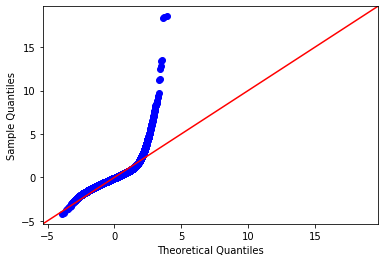

In [52]:
# QQ plot to see if our data is linear
fig1 = plt.figure(figsize = (12,6))
fig1 = sm.graphics.qqplot(model1.resid,fit=True, line='45');

Wow, that's a really bad QQ plot result. Removing outliers will hopefully fix this issue

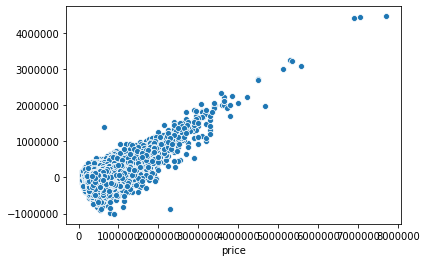

In [53]:
# I have a feeling that this scatterplot will show our data is heteroscadastic
# But for good measure will go ahead and make it
sns.scatterplot(house_data['price'], model1.resid, );

This visual clearly shows that we have some outliers in price. Now we will move on to remove them and see the difference.

In [54]:
# Function for running models and checking the data's changes
def model_fun(df, target='price', test_size=0.25):
    X = df.drop([target], axis=1)
    y = df[[target]]    
# Defining training test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size, 
                                                        random_state=123)
# Defining df with the split data
    df_train = pd.concat([y_train, X_train], axis=1)
    df_test = pd.concat([y_test, X_test], axis=1) 
# Getting the categorical columns
    cat_cols = df_train.select_dtypes('object').columns
# Making the model summary
    features = '+'.join(df_train.drop(columns=target).columns)
# Looping through categoricals to make the formula
    for col in cat_cols:
        features = features.replace(col,f'C({col})')   
    formula = target + '~' + features
    model = smf.ols(formula, df_train).fit()
# QQ plot of the residuals for normality
    fig, axes = plt.subplots(ncols=2, figsize=(20, 5))
    sm.graphics.qqplot(model.resid, fit=True, line='45', ax=axes[0])
    axes[0].set_title('QQ Plot of Residuals', fontsize=20)
# Homoscedasticity of Residuals
    ax=axes[1]
    ax.scatter(df_train['price'], model.resid)
    ax.axhline(0, color='red')
    axes[1].set_title('Homoscedasticity of Residuals', fontsize=20)
    plt.show();

# Getting the predicted y values from the model
    y_predicted = model.predict(X_test)
    
# Plotting a scatterplot of the training vs original test data prices e
    plt.figure(figsize=(20,5))
    g = sns.scatterplot(range(len(y_predicted[:200])), y_predicted[:200], 
                        label='Predicted Prices')
    g = sns.scatterplot(range(len(y_test[:200])), y_test.price[:200], 
                        label='Actual Prices')

# Visual titles, labels, and legends of the plots
    plt.title('Comparison of predicted vs actual price', 
              fontdict={'fontsize':20})
    plt.xlabel('Values')
    plt.ylabel('Prices')
    plt.legend()
    plt.show();
    
# Generating the r2 for the test data to compare to the train data 
    r2_test = r2_score(y_test, y_predicted)
    print('Model test data R2 score:', r2_test)
# Displaying everything
    display(model.summary())
    return model

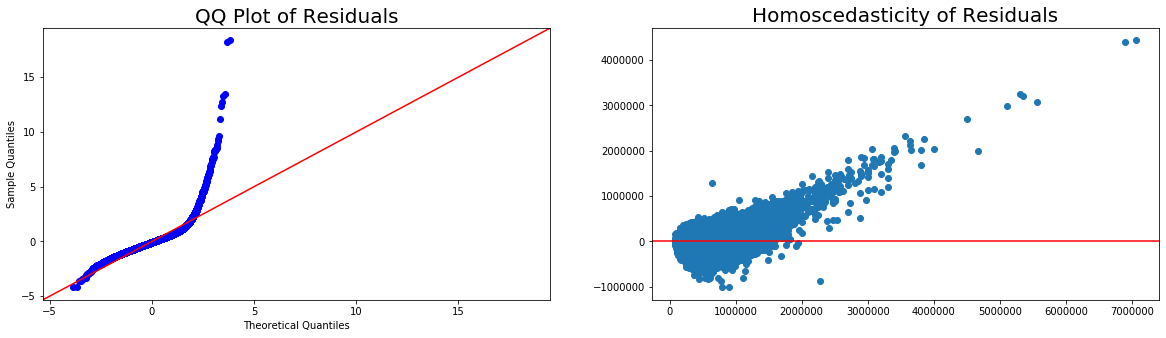

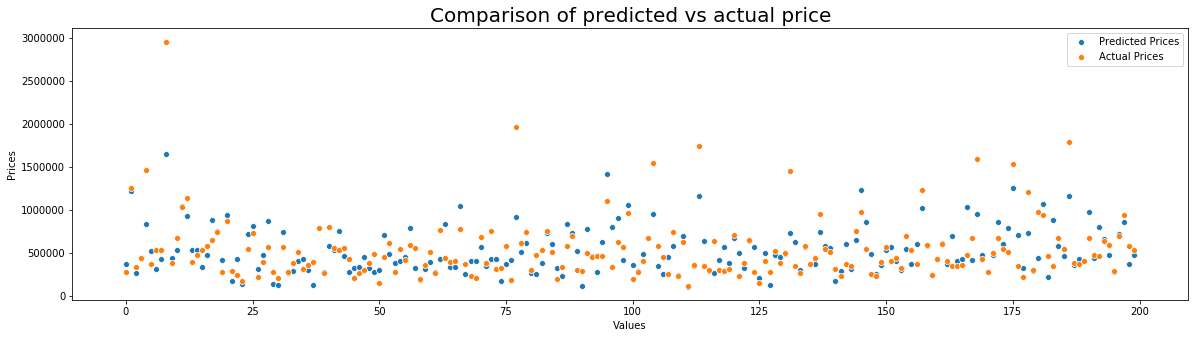

Model test data R2 score: 0.5769233330664367


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     935.1
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        17:22:57   Log-Likelihood:            -2.2373e+05
No. Observations:               16197   AIC:                         4.475e+05
Df Residuals:                   16173   BIC:                         4.477e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -4.808e+05    5.2e+04     -9.243      0.000   -5.83e+05   -3.79e+05
C(condition)[T.2]  -9.68e+04   5.41e+04     -1.790      0.073   -2.03e+05    9197.074
C(condition)[T.3] -1.554e+05   4.95e+04     -3.139      0.002   -2.52e+05   -5.84e+04
C(condition)[T.4] -9.473e+04   4.95e+04     -1.912      0.056   -1.92e+05    2389.025
C(condition)[T.5] -8747.8845   4.99e+04     -0.175      0.861   -1.07e+05     8.9e+04
C(month)[T.2]      6191.9243   1.19e+04      0.520      0.603   -1.72e+04    2.95e+04
C(month)[T.3]      3.949e+04    1.1e+04      3.600      0.000     1.8e+04     6.1e+04
C(month)[T.4]      2.668e+04   5379.957      4.959      0.000    1.61e+04    3.72e+04
C(month)[T.5]     -6962.2774   5240.774     -1.328      0.184   -1.72e+04    3310.220
C(month)[T.6]     -1326.8814   5409.996     -0.245      0.806   -1.19e+04    9277.309
C(month)[T.7]     -1627.2890   5509.356     -0.295      0.768   -1.24e+04    9171.658
C(month)[T.8]      4080.7258   5705.019      0.715      0.474   -7101.742    1.53e+04
C(month)[T.9]      1463.3548   5846.190      0.250      0.802   -9995.824    1.29e+04
C(month)[T.10]     7739.9273   5918.490      1.308      0.191   -3860.968    1.93e+04
C(month)[T.11]     5867.7734   6438.161      0.911      0.362   -6751.734    1.85e+04
C(month)[T.12]    -8742.3037   6387.439     -1.369      0.171   -2.13e+04    3777.784
C(seasons)[T.2]    1.839e+04   7139.580      2.576      0.010    4398.267    3.24e+04
C(seasons)[T.3]    3916.7917   7214.104      0.543      0.587   -1.02e+04    1.81e+04
C(seasons)[T.4]    4865.3970   7338.479      0.663      0.507   -9518.835    1.92e+04
bedrooms          -3.969e+04   2568.949    -15.449      0.000   -4.47e+04   -3.47e+04
bathrooms          -2.04e+04   4266.996     -4.780      0.000   -2.88e+04    -1.2e+04
sqft_living         229.7115      8.113     28.315      0.000     213.810     245.613
floors             2497.6544   4742.734      0.527      0.598   -6798.629    1.18e+04
grade               1.13e+05   2753.862     41.033      0.000    1.08e+05    1.18e+05
sqft_above          -29.6078      8.922     -3.318      0.001     -47.096     -12.119
was_renovated      1.787e+05   1.02e+04     17.575      0.000    1.59e+05    1.99e+05
has_basement       2.967e+04   6936.224      4.278      0.000    1.61e+04    4.33e+04
==============================================================================
Omnibus:                    12599.845   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           730991.015
Skew:                           3.257   Prob(JB):                         0.00
Kurtosis:                      35.260   Cond. No.                     1.09e+16
==============================================================================

Warnings:
[1] Standard Error

In [55]:
functionmodel1 = model_fun(house_data)

# Data Cleaning

### Outlier Removal

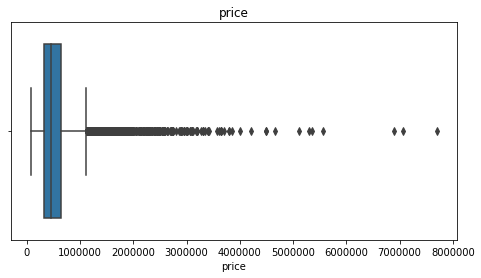

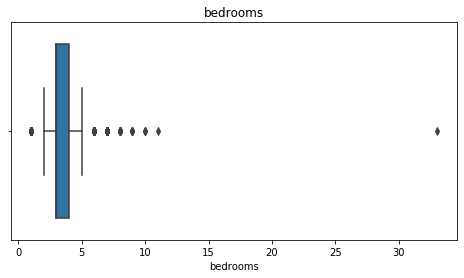

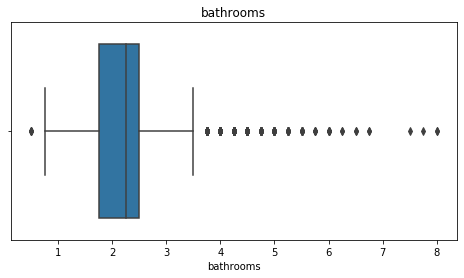

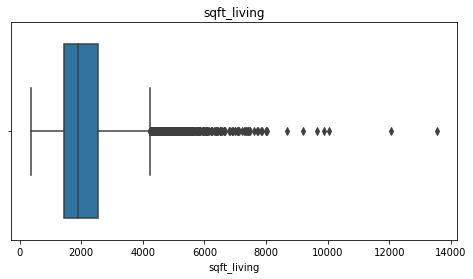

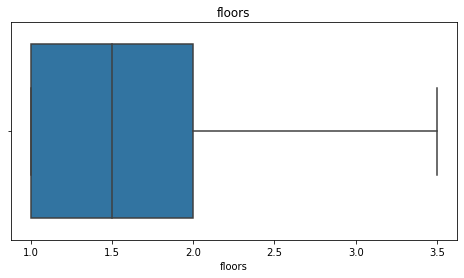

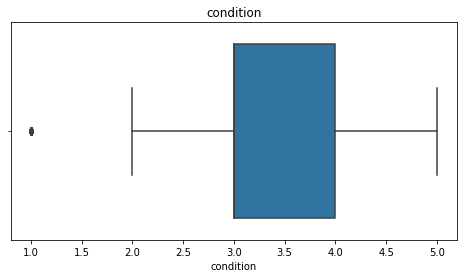

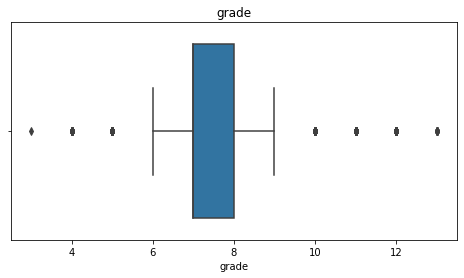

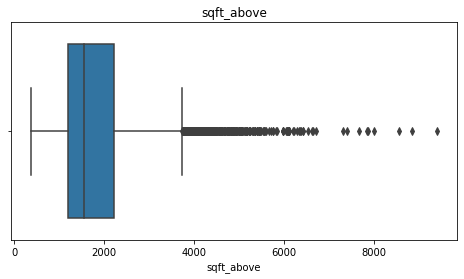

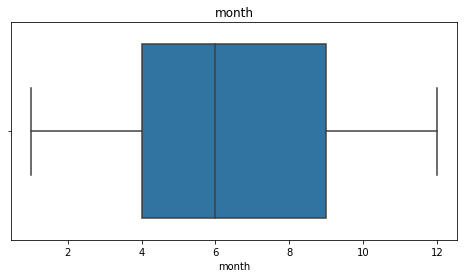

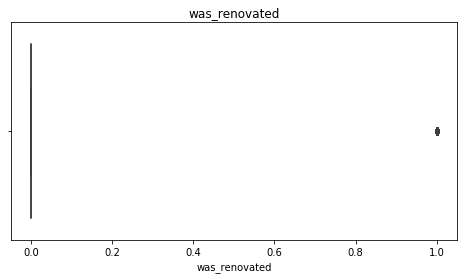

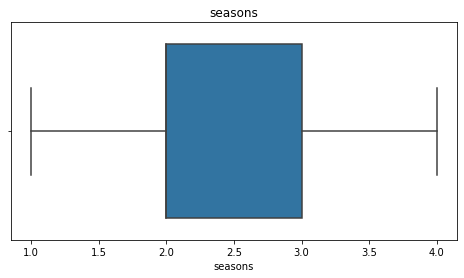

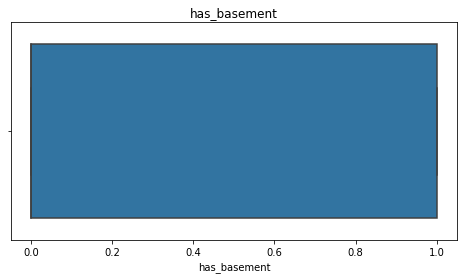

In [56]:
# Let's start by making some boxplots to see if there are obvious outliers
for column in house_data.columns:
    plt.figure(figsize = (8,4))
    sns.boxplot(house_data[column])
    plt.title('{}'.format(column))
    plt.show()

In [57]:
# After researching outlier removal 
# and exploring our data it is best to do IQR type outlier removal methods

def outliersiqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    threshold = iqr * 1.5
    outliers = (data < q1 - threshold) | (data > q3 + threshold)
    outliers = pd.Series(outliers, index=data.index)
    return outliers

In [58]:
# Function to make an outlier column which we will then remove outliers from
def outlierscolumn(df, columns, verbose=True):
    new_df = df.copy()
    for col in columns:
        outliers = outliersiqr(new_df[col])
        if verbose:
            print(f'{outliers.sum()} outliers found in {col}')
        new_df[f'{col}_outliers'] = outliers
    return new_df

In [59]:
# Feeding in the numerical columns for identifying outliers
num_cols = list(house_data.select_dtypes('number').columns)

# Saving the new dataframe with outlier columns added
df2 = outlierscolumn(house_data, num_cols)

1158 outliers found in price
530 outliers found in bedrooms
561 outliers found in bathrooms
571 outliers found in sqft_living
0 outliers found in floors
1905 outliers found in grade
610 outliers found in sqft_above
744 outliers found in was_renovated
0 outliers found in has_basement


In [60]:
df2.head()

,price,bedrooms,bathrooms,sqft_living,floors,condition,grade,sqft_above,month,was_renovated,seasons,has_basement,price_outliers,bedrooms_outliers,bathrooms_outliers,sqft_living_outliers,floors_outliers,grade_outliers,sqft_above_outliers,was_renovated_outliers,has_basement_outliers
0,221900.000,3,1.000,1180,1.000,3,7,1180,10,0,4,0,False,False,False,False,False,False,False,False,False
1,538000.000,3,2.250,2570,2.000,3,7,2170,12,1,4,1,False,False,False,False,False,False,False,True,False
2,180000.000,2,1.000,770,1.000,3,6,770,2,0,1,0,False,False,False,False,False,False,False,False,False
3,604000.000,4,3.000,1960,1.000,5,7,1050,12,0,4,1,False,False,False,False,False,False,False,False,False
4,510000.000,3,2.000,1680,1.000,3,8,1680,2,0,1,0,False,False,False,False,False,False,False,False,False


In [61]:
df2.shape

(21597, 21)

In [62]:
# Dropping columns that are either continous or boolean (yes or no, has or doesn't have)
df2= df2.drop(columns=['was_renovated_outliers', 'has_basement_outliers', 'bedrooms_outliers',  
                        'bathrooms_outliers', 'grade_outliers'])

In [63]:
df2.head()

,price,bedrooms,bathrooms,sqft_living,floors,condition,grade,sqft_above,month,was_renovated,seasons,has_basement,price_outliers,sqft_living_outliers,floors_outliers,sqft_above_outliers
0,221900.000,3,1.000,1180,1.000,3,7,1180,10,0,4,0,False,False,False,False
1,538000.000,3,2.250,2570,2.000,3,7,2170,12,1,4,1,False,False,False,False
2,180000.000,2,1.000,770,1.000,3,6,770,2,0,1,0,False,False,False,False
3,604000.000,4,3.000,1960,1.000,5,7,1050,12,0,4,1,False,False,False,False
4,510000.000,3,2.000,1680,1.000,3,8,1680,2,0,1,0,False,False,False,False


In [64]:
# Creating a list of the outlier columns
outliercols = []
for col in df2.columns:
    if 'outliers' in col:
        outliercols.append(col)
outliercols

['price_outliers',
 'sqft_living_outliers',
 'floors_outliers',
 'sqft_above_outliers']

In [65]:
# Filtering the outliers out of my dataframe and returning only the entries
# that are not outliers for any of the features
for col in outliercols:
    df2 = df2[(df2[col]==False)]
df2.shape

(20068, 16)

In [66]:
# Dropping the outlier columns that were added
for col in outliercols:
    df2.drop(columns=[col], axis=1, inplace=True)

In [67]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20068 entries, 0 to 21596
Data columns (total 12 columns):
price            20068 non-null float64
bedrooms         20068 non-null int64
bathrooms        20068 non-null float64
sqft_living      20068 non-null int64
floors           20068 non-null float64
condition        20068 non-null object
grade            20068 non-null int64
sqft_above       20068 non-null int64
month            20068 non-null object
was_renovated    20068 non-null int32
seasons          20068 non-null object
has_basement     20068 non-null int64
dtypes: float64(3), int32(1), int64(5), object(3)
memory usage: 1.9+ MB


In [68]:
df2.describe()

,price,bedrooms,bathrooms,sqft_living,floors,grade,sqft_above,was_renovated,has_basement
count,20068.000,20068.000,20068.000,20068.000,20068.000,20068.000,20068.000,20068.000,20068.000
mean,469621.176,3.312,2.027,1931.935,1.467,7.491,1668.318,0.031,0.373
std,201681.837,0.899,0.687,708.210,0.536,0.993,666.731,0.172,0.484
min,78000.000,1.000,0.500,370.000,1.000,3.000,370.000,0.000,0.000
25%,313500.000,3.000,1.500,1390.000,1.000,7.000,1170.000,0.000,0.000
50%,432500.000,3.000,2.000,1840.000,1.000,7.000,1500.000,0.000,0.000
75%,592500.000,4.000,2.500,2400.000,2.000,8.000,2060.000,0.000,1.000
max,1120000.000,33.000,5.750,4230.000,3.500,11.000,3740.000,1.000,1.000


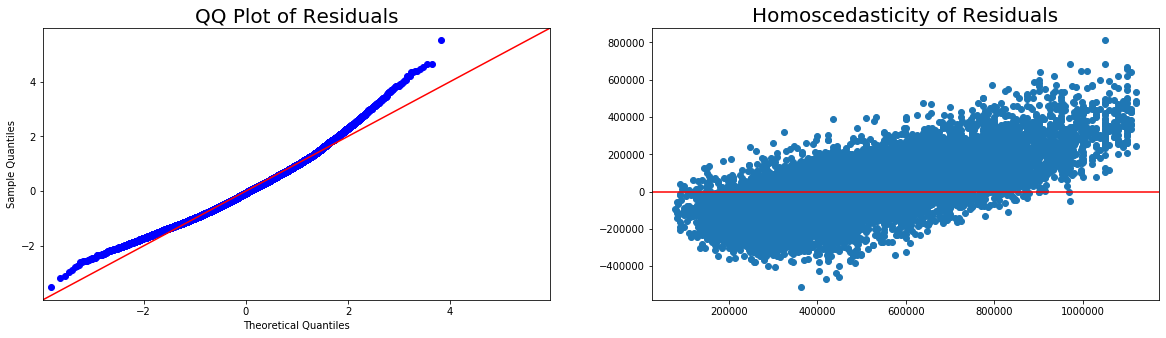

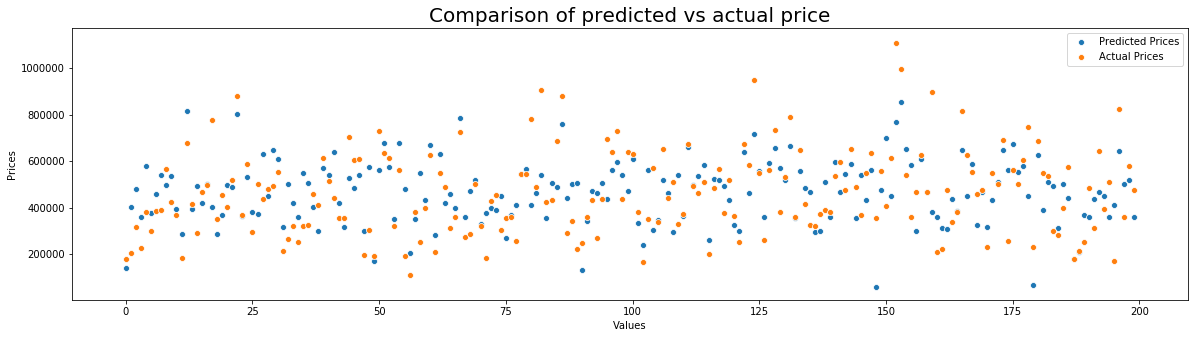

Model test data R2 score: 0.4751722024051128


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     590.1
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        17:23:03   Log-Likelihood:            -2.0045e+05
No. Observations:               15051   AIC:                         4.010e+05
Df Residuals:                   15027   BIC:                         4.011e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -3.235e+05   3.19e+04    -10.153      0.000   -3.86e+05   -2.61e+05
C(condition)[T.2] -5.069e+04   3.28e+04     -1.545      0.122   -1.15e+05    1.36e+04
C(condition)[T.3] -4.711e+04   3.02e+04     -1.559      0.119   -1.06e+05    1.21e+04
C(condition)[T.4] -5791.2196   3.02e+04     -0.191      0.848   -6.51e+04    5.35e+04
C(condition)[T.5]  6.025e+04   3.05e+04      1.978      0.048     529.649     1.2e+05
C(month)[T.2]      2222.8921   7608.841      0.292      0.770   -1.27e+04    1.71e+04
C(month)[T.3]      2.146e+04   6986.835      3.072      0.002    7769.437    3.52e+04
C(month)[T.4]      1.773e+04   3418.085      5.188      0.000     1.1e+04    2.44e+04
C(month)[T.5]     -3545.2406   3336.567     -1.063      0.288   -1.01e+04    2994.836
C(month)[T.6]     -2205.9001   3441.139     -0.641      0.522   -8950.952    4539.151
C(month)[T.7]       711.8424   3446.028      0.207      0.836   -6042.792    7466.477
C(month)[T.8]      1019.5355   3597.821      0.283      0.777   -6032.633    8071.704
C(month)[T.9]      -293.6030   3703.245     -0.079      0.937   -7552.415    6965.209
C(month)[T.10]     6978.9263   3738.372      1.867      0.062    -348.739    1.43e+04
C(month)[T.11]     -855.9253   4088.086     -0.209      0.834   -8869.073    7157.222
C(month)[T.12]    -7217.6882   4076.926     -1.770      0.077   -1.52e+04     773.584
C(seasons)[T.2]    1.198e+04   4561.939      2.626      0.009    3039.087    2.09e+04
C(seasons)[T.3]    1437.7749   4602.476      0.312      0.755   -7583.638    1.05e+04
C(seasons)[T.4]   -1094.6873   4686.610     -0.234      0.815   -1.03e+04    8091.639
bedrooms          -1.145e+04   1677.585     -6.827      0.000   -1.47e+04   -8165.193
bathrooms         -2.518e+04   2787.811     -9.032      0.000   -3.06e+04   -1.97e+04
sqft_living         103.1389      5.897     17.490      0.000      91.580     114.698
floors             2.694e+04   3083.004      8.738      0.000    2.09e+04     3.3e+04
grade              8.554e+04   1831.889     46.694      0.000    8.19e+04    8.91e+04
sqft_above            0.7092      6.399      0.111      0.912     -11.833      13.252
was_renovated      1.033e+05   6922.914     14.923      0.000    8.97e+04    1.17e+05
has_basement       4.888e+04   4596.245     10.634      0.000    3.99e+04    5.79e+04
==============================================================================
Omnibus:                      854.317   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1073.098
Skew:                           0.562   Prob(JB):                    9.54e-234
Kurtosis:                       3.671   Cond. No.                     1.07e+16
==============================================================================

Warnings:
[1] Standard Error

In [69]:
# Time to make a model to see the difference
functionmodel2 = model_fun(df2)

Notes: This is some improvement from our last model. We can see that the QQ plot is better distributed alone our line of fit. Homodescedasticisity is also better and fits the line better. We can still improve more with other transformations possibly.

Our R-squared value is very low though which means that we are not doing a good job of explaining what features influence the model.

In [70]:
df2.bedrooms.value_counts()

3     9563
4     6097
2     2736
5     1230
6      207
1      195
7       25
8        8
9        3
10       2
11       1
33       1
Name: bedrooms, dtype: int64

In [71]:
# Removing the obvious bedroom outliers here
df2 = df2[(df2['bedrooms']!=33)]

In [72]:
df2.bedrooms.value_counts()

3     9563
4     6097
2     2736
5     1230
6      207
1      195
7       25
8        8
9        3
10       2
11       1
Name: bedrooms, dtype: int64

In [73]:
df2.describe()

,price,bedrooms,bathrooms,sqft_living,floors,grade,sqft_above,was_renovated,has_basement
count,20067.000,20067.000,20067.000,20067.000,20067.000,20067.000,20067.000,20067.000,20067.000
mean,469612.686,3.311,2.027,1931.950,1.467,7.491,1668.349,0.031,0.373
std,201683.276,0.874,0.687,708.225,0.536,0.993,666.733,0.172,0.484
min,78000.000,1.000,0.500,370.000,1.000,3.000,370.000,0.000,0.000
25%,313500.000,3.000,1.500,1390.000,1.000,7.000,1170.000,0.000,0.000
50%,432500.000,3.000,2.000,1840.000,1.000,7.000,1500.000,0.000,0.000
75%,592500.000,4.000,2.500,2400.000,2.000,8.000,2060.000,0.000,1.000
max,1120000.000,11.000,5.750,4230.000,3.500,11.000,3740.000,1.000,1.000


In [74]:
# Removing the obvious bedroom outliers here
df2 = df2[(df2['bathrooms']!=5.75)]

In [75]:
# 1/4 bathroom is maybe a real thing
# Could round up and down

In [76]:
df2.describe()

,price,bedrooms,bathrooms,sqft_living,floors,grade,sqft_above,was_renovated,has_basement
count,20066.000,20066.000,20066.000,20066.000,20066.000,20066.000,20066.000,20066.000,20066.000
mean,469609.178,3.310,2.027,1931.862,1.467,7.491,1668.248,0.031,0.373
std,201687.689,0.874,0.686,708.132,0.536,0.993,666.595,0.172,0.484
min,78000.000,1.000,0.500,370.000,1.000,3.000,370.000,0.000,0.000
25%,313500.000,3.000,1.500,1390.000,1.000,7.000,1170.000,0.000,0.000
50%,432500.000,3.000,2.000,1840.000,1.000,7.000,1500.000,0.000,0.000
75%,592500.000,4.000,2.500,2400.000,2.000,8.000,2060.000,0.000,1.000
max,1120000.000,11.000,5.250,4230.000,3.500,11.000,3740.000,1.000,1.000


### Scaling

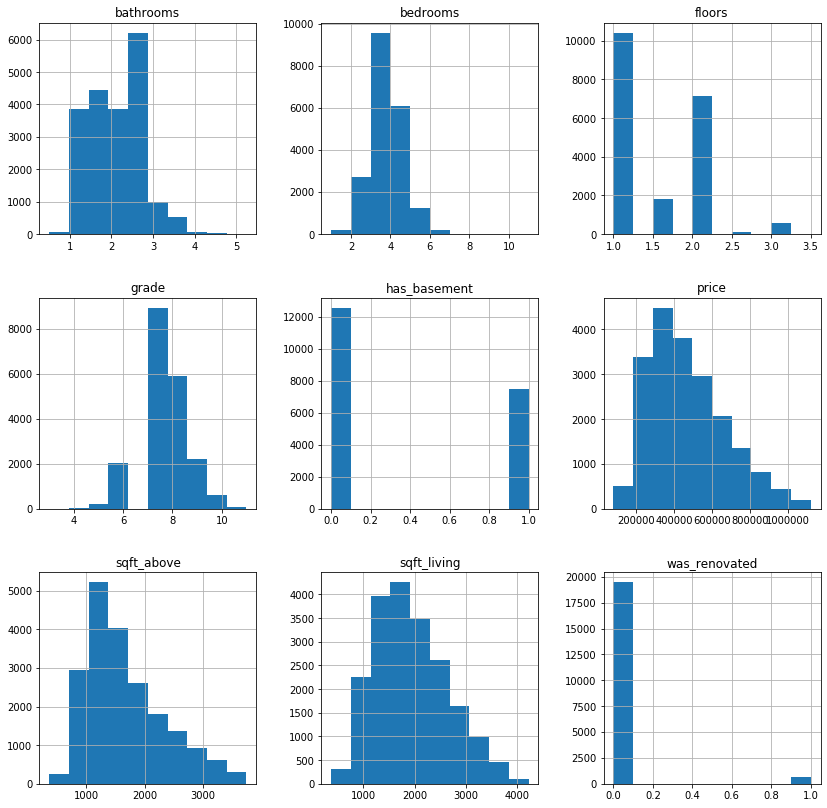

In [77]:
# There are some outliers and skewness still
# Scaling our data may improve our r2 and make our data more normal
df2.hist(figsize = (14,14));

In [78]:
cont = ['price', 'bathrooms', 'bedrooms', 'floors', 'grade', 
       'sqft_above', 'sqft_living']
df2cont = df2[cont]

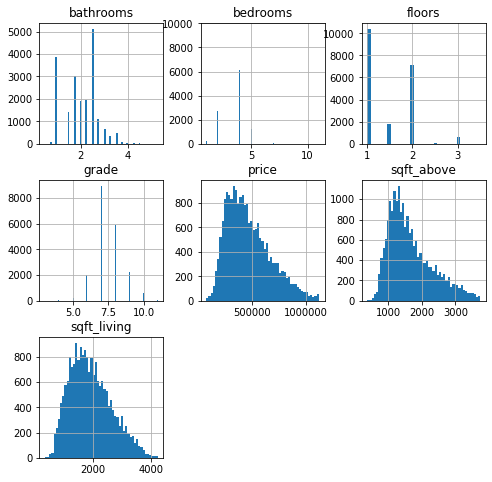

In [79]:
df2cont.hist(figsize  = [8, 8], bins='auto');

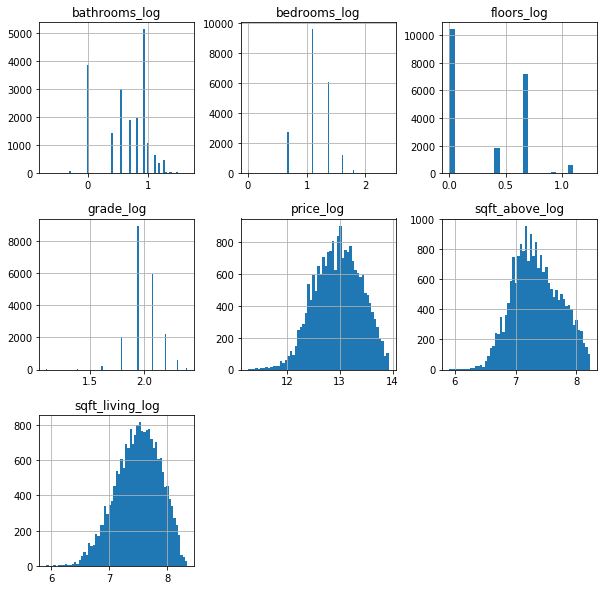

In [80]:
log_names = [f'{column}_log' for column in df2cont.columns]

df2log = np.log(df2cont)
df2log.columns = log_names
df2log.hist(figsize=(10, 10), bins='auto')
fig.tight_layout();

In [81]:
features = '+'.join(df2.drop('price', axis = 1).columns)
formula = 'price ~' + features
model1 = smf.ols(formula, df2).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     789.1
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        17:23:12   Log-Likelihood:            -2.6710e+05
No. Observations:               20066   AIC:                         5.342e+05
Df Residuals:                   20042   BIC:                         5.344e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -3.146e+05   2.91e+04    -10.797      0.000   -3.72e+05   -2.57e+05
condition[T.2] -6.009e+04   2.99e+04     -2.011      0.044   -1.19e+05   -1527.250
condition[T.3] -5.036e+04   2.77e+04     -1.815      0.070   -1.05e+05    4027.931
condition[T.4] -1.061e+04   2.78e+04     -0.382      0.702    -6.5e+04    4.38e+04
condition[T.5]  5.282e+04   2.79e+04      1.890      0.059   -1958.650    1.08e+05
month[T.2]      1272.3860   6469.160      0.197      0.844   -1.14e+04     1.4e+04
month[T.3]      2.503e+04   5982.131      4.184      0.000    1.33e+04    3.68e+04
month[T.4]       2.01e+04   2925.674      6.869      0.000    1.44e+04    2.58e+04
month[T.5]     -1051.7709   2859.259     -0.368      0.713   -6656.153    4552.611
month[T.6]     -4664.3020   2953.336     -1.579      0.114   -1.05e+04    1124.480
month[T.7]      1723.8663   2983.000      0.578      0.563   -4123.058    7570.791
month[T.8]       348.9925   3090.919      0.113      0.910   -5709.464    6407.449
month[T.9]      1018.1999   3178.348      0.320      0.749   -5211.624    7248.023
month[T.10]     4932.9930   3228.404      1.528      0.127   -1394.946    1.13e+04
month[T.11]      613.7579   3511.786      0.175      0.861   -6269.632    7497.148
month[T.12]    -6354.1311   3475.356     -1.828      0.068   -1.32e+04     457.854
seasons[T.2]    1.438e+04   3893.740      3.693      0.000    6749.273     2.2e+04
seasons[T.3]    3091.0587   3931.018      0.786      0.432   -4614.060    1.08e+04
seasons[T.4]    -807.3802   4001.628     -0.202      0.840   -8650.901    7036.140
bedrooms       -1.341e+04   1529.211     -8.769      0.000   -1.64e+04   -1.04e+04
bathrooms      -2.619e+04   2401.005    -10.908      0.000   -3.09e+04   -2.15e+04
sqft_living      105.0107      5.094     20.613      0.000      95.025     114.996
floors           2.77e+04   2655.340     10.434      0.000    2.25e+04    3.29e+04
grade            8.55e+04   1578.657     54.158      0.000    8.24e+04    8.86e+04
sqft_above        -0.9524      5.524     -0.172      0.863     -11.779       9.875
was_renovated   1.056e+05   6025.718     17.518      0.000    9.37e+04    1.17e+05
has_basement     4.98e+04   3970.659     12.541      0.000     4.2e+04    5.76e+04
==============================================================================
Omnibus:                     1082.836   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1337.369
Skew:                           0.550   Prob(JB):                    3.93e-291
Kurtosis:                       3.623   Cond. No.                     1.07e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest

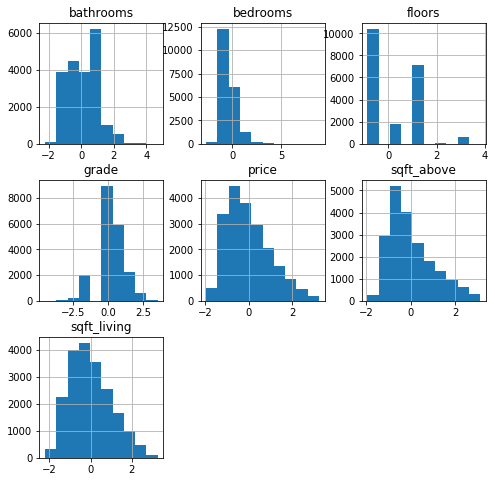

In [82]:
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

featuresdf2 = df2cont.apply(normalize)

featuresdf2.hist(figsize  = [8, 8]);

In [83]:
features = '+'.join(df2.drop('price', axis = 1).columns)
formula = 'price ~' + features
model1 = smf.ols(formula, df2).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     789.1
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        17:23:14   Log-Likelihood:            -2.6710e+05
No. Observations:               20066   AIC:                         5.342e+05
Df Residuals:                   20042   BIC:                         5.344e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -3.146e+05   2.91e+04    -10.797      0.000   -3.72e+05   -2.57e+05
condition[T.2] -6.009e+04   2.99e+04     -2.011      0.044   -1.19e+05   -1527.250
condition[T.3] -5.036e+04   2.77e+04     -1.815      0.070   -1.05e+05    4027.931
condition[T.4] -1.061e+04   2.78e+04     -0.382      0.702    -6.5e+04    4.38e+04
condition[T.5]  5.282e+04   2.79e+04      1.890      0.059   -1958.650    1.08e+05
month[T.2]      1272.3860   6469.160      0.197      0.844   -1.14e+04     1.4e+04
month[T.3]      2.503e+04   5982.131      4.184      0.000    1.33e+04    3.68e+04
month[T.4]       2.01e+04   2925.674      6.869      0.000    1.44e+04    2.58e+04
month[T.5]     -1051.7709   2859.259     -0.368      0.713   -6656.153    4552.611
month[T.6]     -4664.3020   2953.336     -1.579      0.114   -1.05e+04    1124.480
month[T.7]      1723.8663   2983.000      0.578      0.563   -4123.058    7570.791
month[T.8]       348.9925   3090.919      0.113      0.910   -5709.464    6407.449
month[T.9]      1018.1999   3178.348      0.320      0.749   -5211.624    7248.023
month[T.10]     4932.9930   3228.404      1.528      0.127   -1394.946    1.13e+04
month[T.11]      613.7579   3511.786      0.175      0.861   -6269.632    7497.148
month[T.12]    -6354.1311   3475.356     -1.828      0.068   -1.32e+04     457.854
seasons[T.2]    1.438e+04   3893.740      3.693      0.000    6749.273     2.2e+04
seasons[T.3]    3091.0587   3931.018      0.786      0.432   -4614.060    1.08e+04
seasons[T.4]    -807.3802   4001.628     -0.202      0.840   -8650.901    7036.140
bedrooms       -1.341e+04   1529.211     -8.769      0.000   -1.64e+04   -1.04e+04
bathrooms      -2.619e+04   2401.005    -10.908      0.000   -3.09e+04   -2.15e+04
sqft_living      105.0107      5.094     20.613      0.000      95.025     114.996
floors           2.77e+04   2655.340     10.434      0.000    2.25e+04    3.29e+04
grade            8.55e+04   1578.657     54.158      0.000    8.24e+04    8.86e+04
sqft_above        -0.9524      5.524     -0.172      0.863     -11.779       9.875
was_renovated   1.056e+05   6025.718     17.518      0.000    9.37e+04    1.17e+05
has_basement     4.98e+04   3970.659     12.541      0.000     4.2e+04    5.76e+04
==============================================================================
Omnibus:                     1082.836   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1337.369
Skew:                           0.550   Prob(JB):                    3.93e-291
Kurtosis:                       3.623   Cond. No.                     1.07e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest

In [84]:
### Attempting to log transform and normalize

In [85]:
# Defining continuous and categorical variables
#cont = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'sqft_above']  
#categorical = ['condition', 'grade', 'month', 'was_renovated', 'seasons', 'has_basement']

In [86]:
# Log transform and normalize
#house_data_cont = house_data[cont]

# log features
#log_names = [f'{column}_log' for column in house_data_cont.columns]

#hdlog = np.log(house_data_cont)
#hdlog.columns = log_names

# normalize (subract mean and divide by std)

#def normalize(feature):
 #   return (feature - feature.mean()) / feature.std()

#hd_log_norm = hdlog.apply(normalize)

In [87]:
#hd_ohe = pd.get_dummies(df2[categorical], drop_first=True)

In [88]:
#preprocessed = pd.concat([hd_log_norm, hd_ohe], axis=1)
#preprocessed.head()

In [89]:
#X = preprocessed.drop('price_log', axis=1)
#y = preprocessed['price_log']

In [90]:
#X_int = sm.add_constant(X)
#model = sm.OLS(y,X_int).fit()
#model.summary()

### Linearity, Normality, & Homoscedasticity

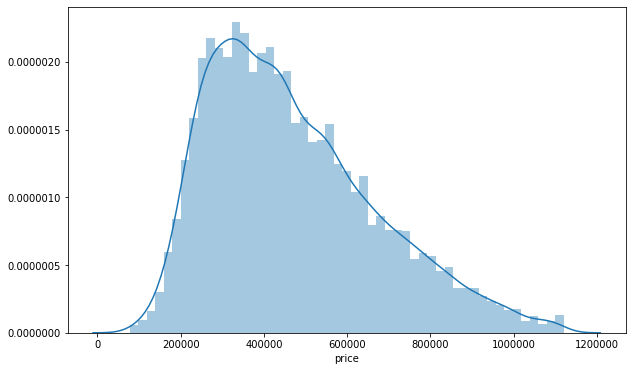

In [91]:
# Let's look at the target price first
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(df2['price'], bins='auto')

# Adjusting the money ticks 
# fmt_money = '${x:,.0f}'

In [92]:
# To start I want to go ahead and limit the target: price column 
# to only have houses in the majority range $0-$1,000,000
df2 = df2[(df2['price']<=1000000)]

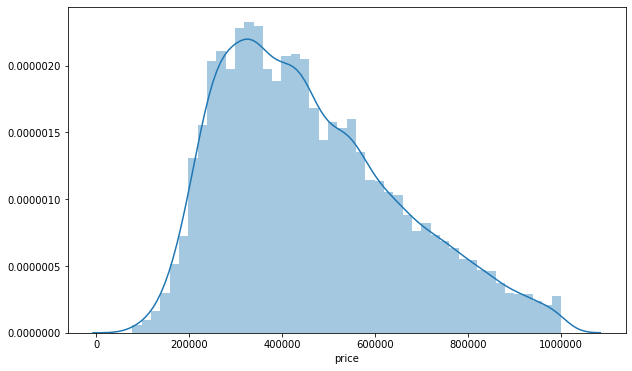

In [93]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(df2['price'], bins='auto')

In [94]:
df2['price'].describe()
# Now our target is limited to 1,000,000 and under

count     19843.000
mean     462944.503
std      192681.912
min       78000.000
25%      311200.000
50%      430000.000
75%      585000.000
max     1000000.000
Name: price, dtype: float64

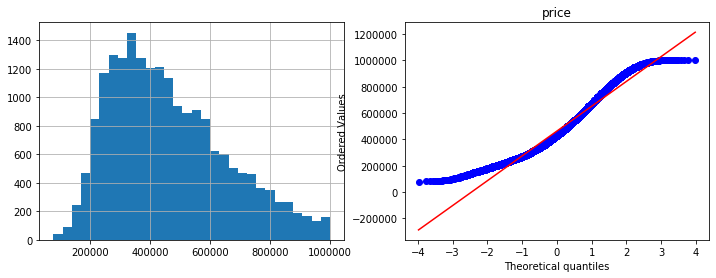

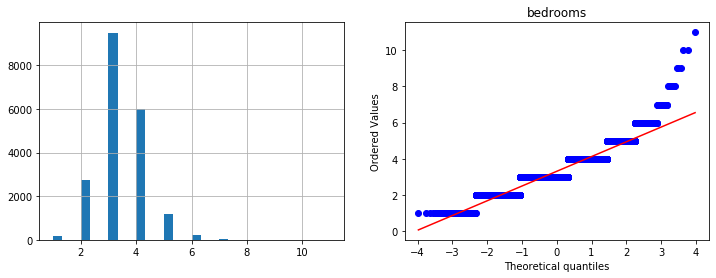

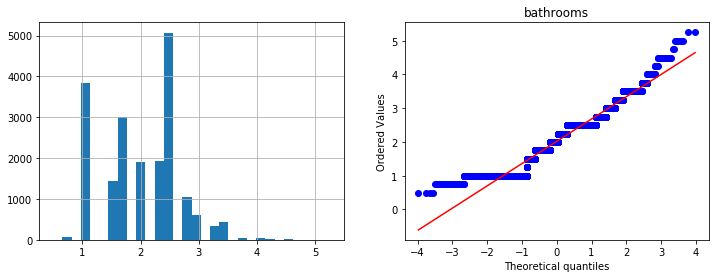

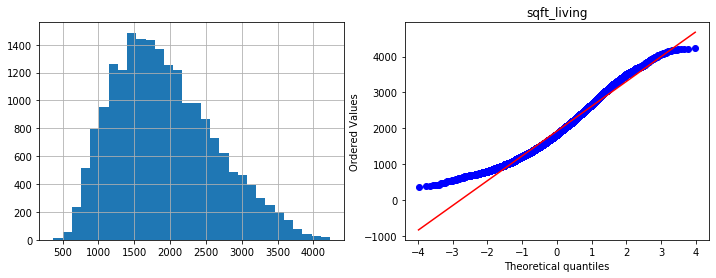

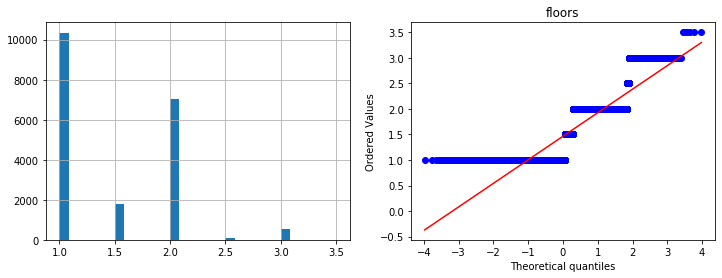

condition


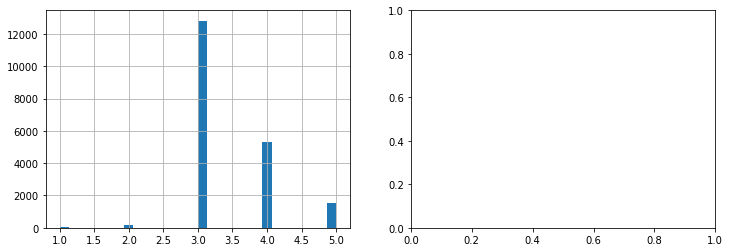

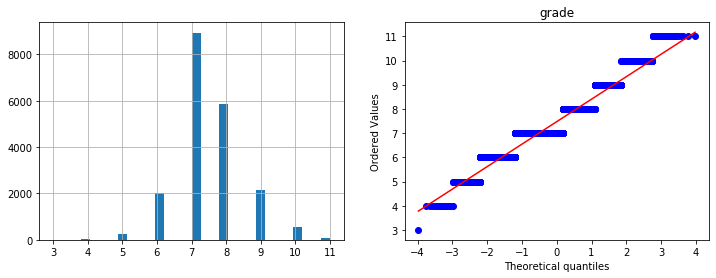

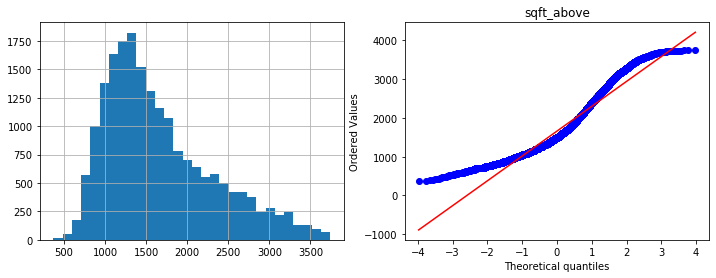

month


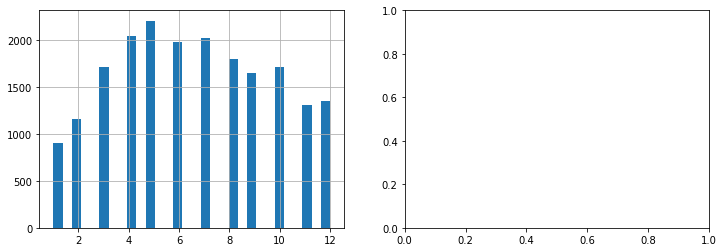

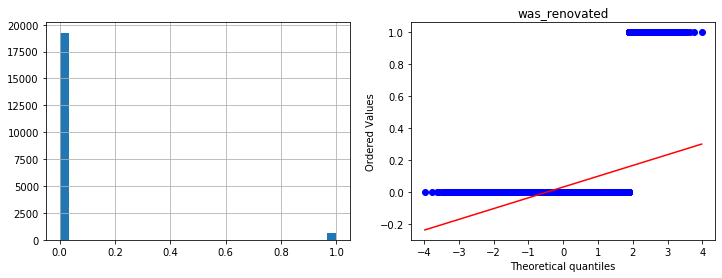

seasons


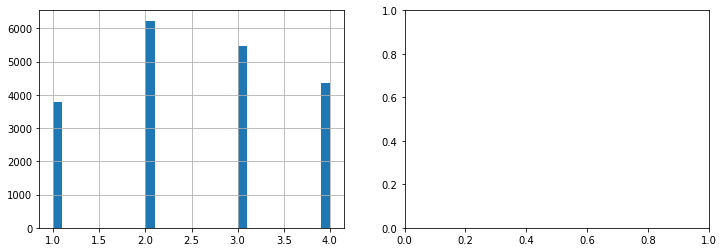

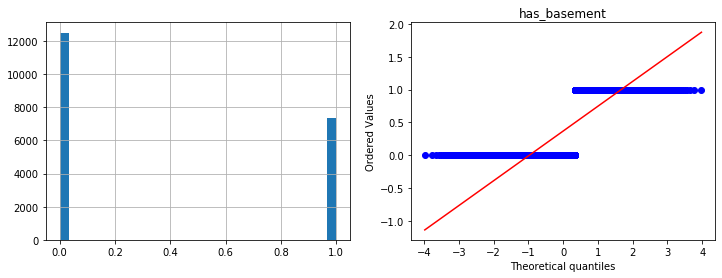

In [95]:
# Function to make vizuals to show normality
def normalityplots (df, column):
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    df[column].hist(bins = 30)
    plt.subplot(1,2,2)
    stats.probplot(df[column], dist = 'norm', plot = plt)
    plt.title('{}'.format(column))
    plt.show()

# Now let's see the results of the outlier removal
for column in df2.columns:
    try: 
        normalityplots(df2, column)
    except: 
        print(column)

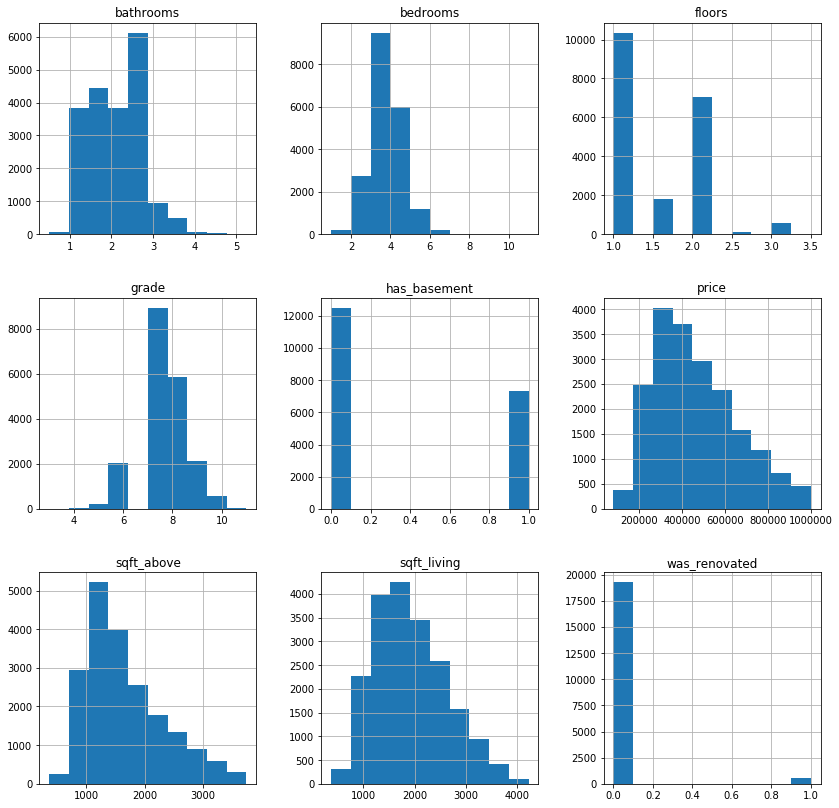

In [96]:
df2.hist(figsize = (14,14));

condition
month
seasons


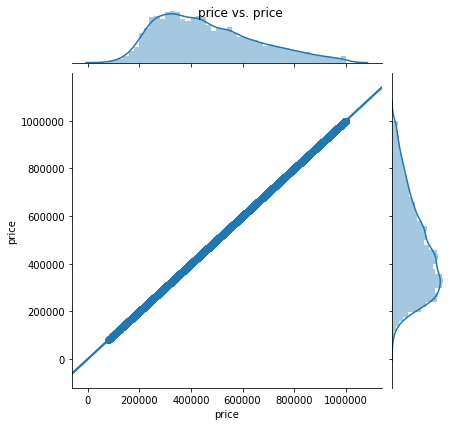

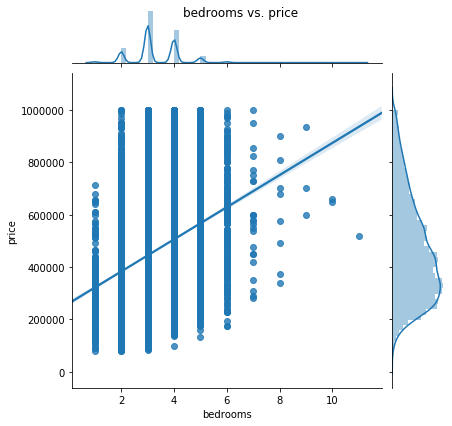

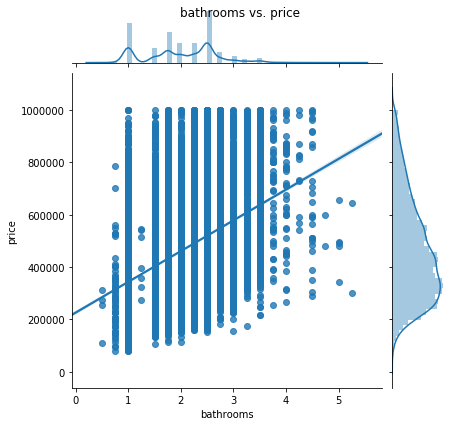

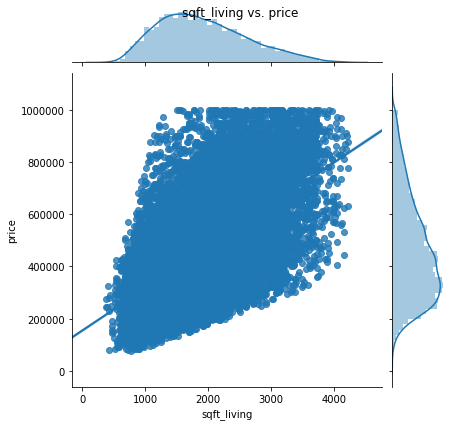

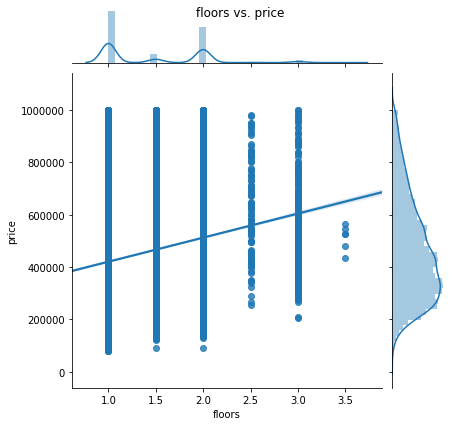

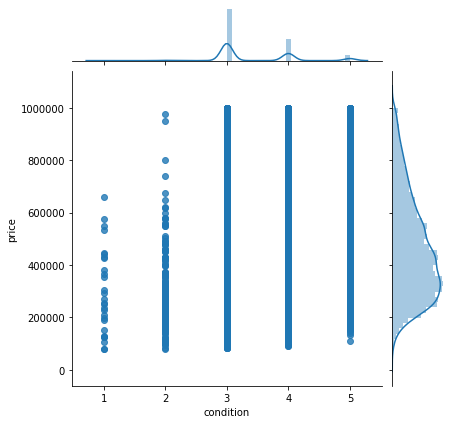

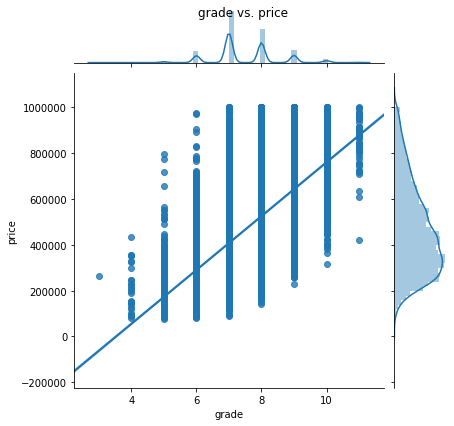

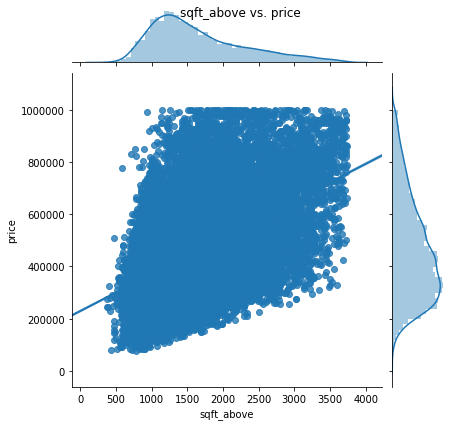

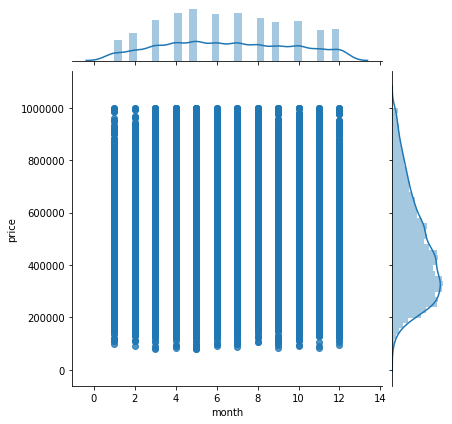

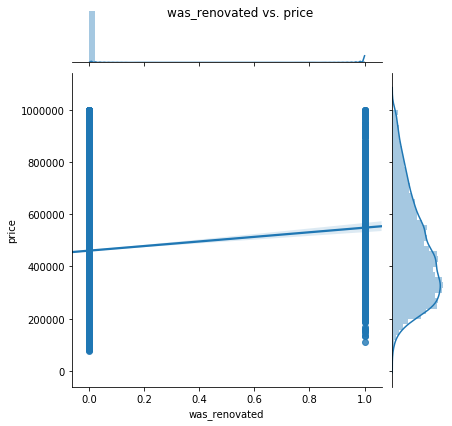

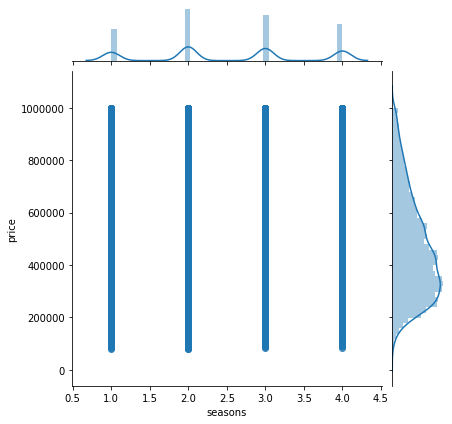

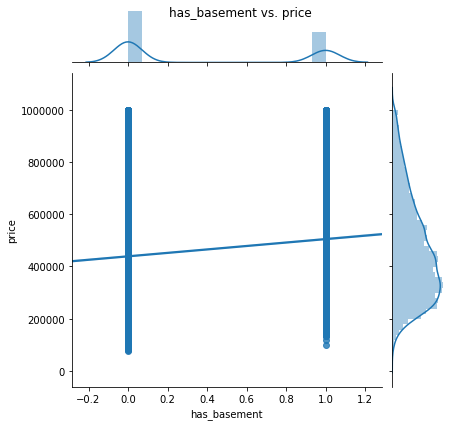

In [97]:
# Creating a function that will create a joint plot to vizualize linearity against our target price
def jointplot(df, col, target = 'price'):
    g = sns.jointplot(data = df, x = col, y = target, kind = 'reg')
    plt.suptitle(f"{col} vs. {target}");
    return g

for col in df2.columns:
    try:
        jointplot(df2, col)
    except: 
        print(col)

Our data and feature columns look a bit more normal now. I will need to drop more columns though before I make a new model as they aren't normally distributed or don't make sense for the model and/or I won't be using it for recommendations of how to improve the house.

### Low p-value Removal

In [98]:
# Function to identify the insignificant p-values
def bad_pvalues(model, verbose=True):
    
#     Pulling out the p-values and identifying the ones above .05
    pvalues = model.pvalues
    bad_features = pvalues[pvalues > .05]
    
#     Excluding the intercept in case it has a high p-value
    if 'Intercept' in bad_features:
        bad_features.remove('Intercept')
        
#      Printing a statement of the bad p-values
    if verbose:
        print(f'{len(bad_features)} bad p-values to be reviewed:\n' 
              + f'{bad_features}')
    return bad_features

In [99]:
model2_bad_pvals = bad_pvalues(model1)

15 bad p-values to be reviewed:
condition[T.3]   0.070
condition[T.4]   0.702
condition[T.5]   0.059
month[T.2]       0.844
month[T.5]       0.713
month[T.6]       0.114
month[T.7]       0.563
month[T.8]       0.910
month[T.9]       0.749
month[T.10]      0.127
month[T.11]      0.861
month[T.12]      0.068
seasons[T.3]     0.432
seasons[T.4]     0.840
sqft_above       0.863
dtype: float64


In [100]:
# We can see from the low values that month has many low p-value features
df3 = df2.copy()
df3.drop(columns=(['month']), inplace=True)
df3.shape

(19843, 11)

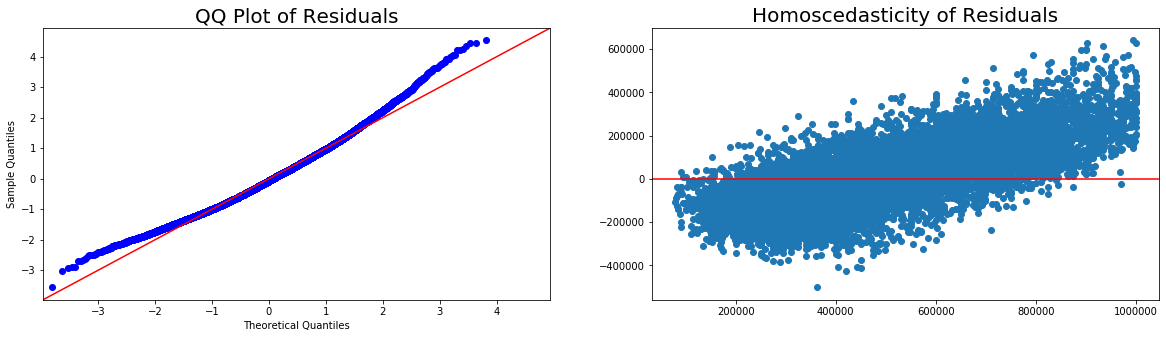

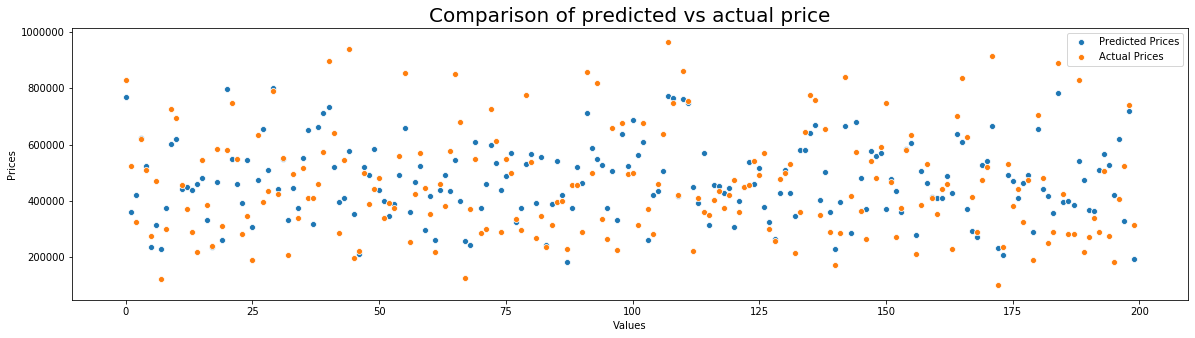

Model test data R2 score: 0.4681387813227734


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     842.1
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        17:24:03   Log-Likelihood:            -1.9759e+05
No. Observations:               14882   AIC:                         3.952e+05
Df Residuals:                   14866   BIC:                         3.953e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.821e+05   3.03e+04     -9.300      0.000   -3.42e+05   -2.23e+05
C(condition)[T.2] -4.084e+04   3.17e+04     -1.289      0.197   -1.03e+05    2.13e+04
C(condition)[T.3] -3.567e+04    2.9e+04     -1.231      0.218   -9.25e+04    2.11e+04
C(condition)[T.4]  4082.4097    2.9e+04      0.141      0.888   -5.28e+04    6.09e+04
C(condition)[T.5]  6.239e+04   2.92e+04      2.135      0.033    5106.732     1.2e+05
C(seasons)[T.2]    9790.1714   3368.870      2.906      0.004    3186.771    1.64e+04
C(seasons)[T.3]   -1545.7766   3456.495     -0.447      0.655   -8320.935    5229.381
C(seasons)[T.4]   -7532.4932   3638.996     -2.070      0.038   -1.47e+04    -399.611
bedrooms           -1.13e+04   1702.779     -6.638      0.000   -1.46e+04   -7965.899
bathrooms          -2.72e+04   2701.450    -10.068      0.000   -3.25e+04   -2.19e+04
sqft_living          90.3944      5.776     15.649      0.000      79.072     101.717
floors              2.74e+04   2967.276      9.233      0.000    2.16e+04    3.32e+04
grade               8.02e+04   1776.146     45.152      0.000    7.67e+04    8.37e+04
sqft_above           10.8921      6.255      1.741      0.082      -1.368      23.152
was_renovated      1.017e+05   6889.345     14.768      0.000    8.82e+04    1.15e+05
has_basement       5.392e+04   4490.600     12.008      0.000    4.51e+04    6.27e+04
==============================================================================
Omnibus:                      576.336   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              653.875
Skew:                           0.480   Prob(JB):                    1.03e-142
Kurtosis:                       3.363   Cond. No.                     1.51e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [101]:
# Model summary to see the changes if significant
functionmodel3 = model_fun(df3)

### Multicolinearity Column/Feature Removal

In [102]:
# Creating a heat map again to see our new data
corr3 = df3.iloc[:,2:] 
corr3.corr().abs().style.background_gradient(cmap='Reds')

,bathrooms,sqft_living,floors,grade,sqft_above,was_renovated,has_basement
bathrooms,1,0.697139,0.498569,0.591108,0.610974,0.0184345,0.13609
sqft_living,0.697139,1,0.325556,0.675924,0.833173,0.0171295,0.186247
floors,0.498569,0.325556,1,0.451225,0.529872,0.00523301,0.282308
grade,0.591108,0.675924,0.451225,1,0.682823,0.0181145,0.00424634
sqft_above,0.610974,0.833173,0.529872,0.682823,1,0.00343167,0.296471
was_renovated,0.0184345,0.0171295,0.00523301,0.0181145,0.00343167,1,0.0248955
has_basement,0.13609,0.186247,0.282308,0.00424634,0.296471,0.0248955,1


In [103]:
# There is a high correlation betweeon sqft_above and sqft_living15
# Note even sure what sqftliving15 is exactly so we will be dropping this column

In [104]:
df4 = df3.copy()
df4= df4.drop(columns=['sqft_living'])

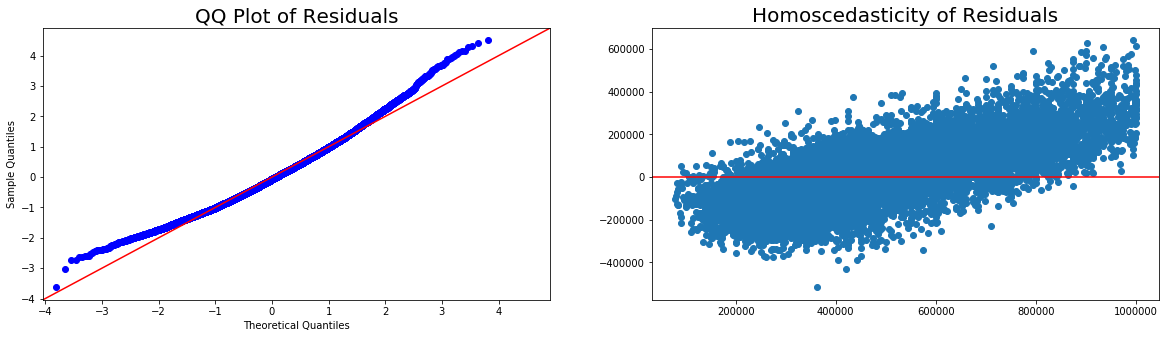

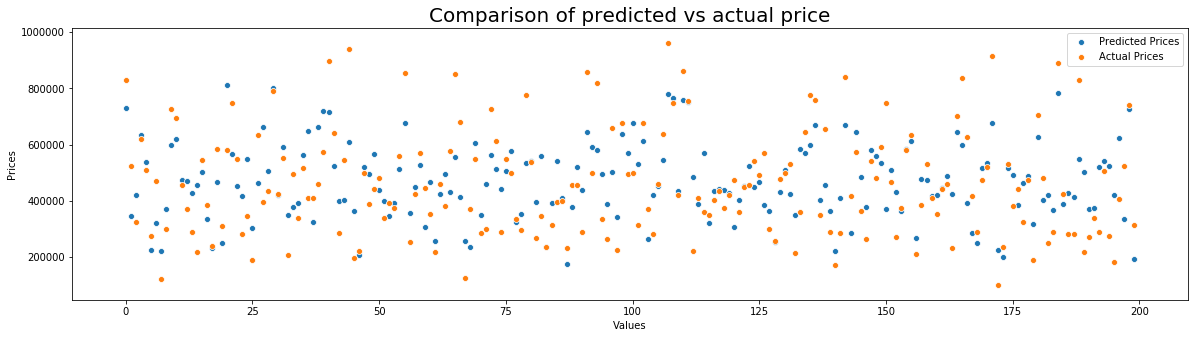

Model test data R2 score: 0.45637002239458135


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     870.4
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        17:24:05   Log-Likelihood:            -1.9771e+05
No. Observations:               14882   AIC:                         3.954e+05
Df Residuals:                   14867   BIC:                         3.956e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -3.04e+05   3.05e+04     -9.953      0.000   -3.64e+05   -2.44e+05
C(condition)[T.2] -4.988e+04   3.19e+04     -1.562      0.118   -1.12e+05    1.27e+04
C(condition)[T.3]  -4.32e+04   2.92e+04     -1.479      0.139      -1e+05    1.41e+04
C(condition)[T.4]   263.0869   2.92e+04      0.009      0.993    -5.7e+04    5.76e+04
C(condition)[T.5]   6.17e+04   2.95e+04      2.094      0.036    3949.370    1.19e+05
C(seasons)[T.2]    9619.4647   3396.374      2.832      0.005    2962.153    1.63e+04
C(seasons)[T.3]   -1341.0531   3484.708     -0.385      0.700   -8171.511    5489.405
C(seasons)[T.4]   -7549.8100   3668.724     -2.058      0.040   -1.47e+04    -358.657
bedrooms          -4915.3316   1666.630     -2.949      0.003   -8182.132   -1648.531
bathrooms         -1.881e+04   2669.344     -7.046      0.000    -2.4e+04   -1.36e+04
floors             1.589e+04   2898.157      5.481      0.000    1.02e+04    2.16e+04
grade              8.309e+04   1780.899     46.658      0.000    7.96e+04    8.66e+04
sqft_above           95.0210      3.224     29.477      0.000      88.702     101.339
was_renovated      1.061e+05   6940.013     15.284      0.000    9.25e+04     1.2e+05
has_basement       1.051e+05   3104.969     33.838      0.000     9.9e+04    1.11e+05
==============================================================================
Omnibus:                      586.957   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              664.034
Skew:                           0.490   Prob(JB):                    6.41e-145
Kurtosis:                       3.334   Cond. No.                     1.00e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  1e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [105]:
# Model to see difference
functionmodel4 = model_fun(df4)

## Interpreations: 
- Final model's R-Sqaured was 4.50
    - While this may seem low, we did not have many features included in our model, therefore we had fewer features to explain price.
- Otherwise, the model's residuals look acceptable, seen from the QQ plot.

In [106]:
df4.describe()

,price,bedrooms,bathrooms,floors,grade,sqft_above,was_renovated,has_basement
count,19843.000,19843.000,19843.000,19843.000,19843.000,19843.000,19843.000,19843.000
mean,462944.503,3.305,2.020,1.464,7.476,1661.245,0.030,0.370
std,192681.912,0.873,0.683,0.536,0.983,663.796,0.170,0.483
min,78000.000,1.000,0.500,1.000,3.000,370.000,0.000,0.000
25%,311200.000,3.000,1.500,1.000,7.000,1160.000,0.000,0.000
50%,430000.000,3.000,2.000,1.000,7.000,1490.000,0.000,0.000
75%,585000.000,4.000,2.500,2.000,8.000,2040.000,0.000,1.000
max,1000000.000,11.000,5.250,3.500,11.000,3740.000,1.000,1.000


# 3. Will multicollinearity affect what feature yields the highest selling price?

Notes: This didn't create too much change. Also to note the warning message at the bottom of the screen is still appearing.

# 1. What outlier removal method is the most effective?

In trying multiple outlier removal methods above and not included in our notebook we found that the most effective outlier removal system was IQR outlier removal. 

Other methods tried that are not included on the notebook and can be found in the "leftovers" notebook:

*Log Transformation

*One Hot Encoding

# 2. What effect does outliers have on our outcomes and overall data?

Above we have created a training model to see the difference that outlier removal had on our data. 

The QQ plot and Homodescacidisity plot show that there was improvement in our residuals

# Recommendations

Homeowners are able to control the following variables/features of their house. My improving or increasing these features the homeowners can possibly increase the worth of their home when selling.
1. Improve the Grade of the Home
2. 
#### Come back and add

In [107]:
functionmodel3.params

Intercept           -282106.230
C(condition)[T.2]    -40841.760
C(condition)[T.3]    -35673.188
C(condition)[T.4]      4082.410
C(condition)[T.5]     62386.473
C(seasons)[T.2]        9790.171
C(seasons)[T.3]       -1545.777
C(seasons)[T.4]       -7532.493
bedrooms             -11303.557
bathrooms            -27198.635
sqft_living              90.394
floors                27396.015
grade                 80195.959
sqft_above               10.892
was_renovated        101739.182
has_basement          53923.341
dtype: float64

In [108]:
# Convert the coefficient series to a sorted dataframe

coeffs_df = functionmodel3.params.to_frame()
coeffs_df.columns = ['coefficients']
coeffs_df = coeffs_df.sort_values('coefficients', ascending = False)
coeffs_df.style.background_gradient(cmap = 'Reds').set_caption('Coefficients')

,coefficients
was_renovated,101739
grade,80196
C(condition)[T.5],62386.5
has_basement,53923.3
floors,27396
C(seasons)[T.2],9790.17
C(condition)[T.4],4082.41
sqft_living,90.3944
sqft_above,10.8921
C(seasons)[T.3],-1545.78


In [109]:
coeffs_df = coeffs_df.transpose()
coeffs_df

,was_renovated,grade,C(condition)[T.5],has_basement,floors,C(seasons)[T.2],C(condition)[T.4],sqft_living,sqft_above,C(seasons)[T.3],C(seasons)[T.4],bedrooms,bathrooms,C(condition)[T.3],C(condition)[T.2],Intercept
coefficients,101739.182,80195.959,62386.473,53923.341,27396.015,9790.171,4082.410,90.394,10.892,-1545.777,-7532.493,-11303.557,-27198.635,-35673.188,-40841.760,-282106.230


In [110]:
def multicol_plot(df):
    
#   Creating a temporary new dataframe
    new_df = df.copy()
    
#   Converting the category types to int so they will show up in the heatmap
    categories = new_df.select_dtypes('category')
    for col in categories:
        new_df[col]= new_df[col].astype('int64')  
        
#   Generating the correlation chart 
    corr = abs(new_df.corr())
    
#   Creating a mask that will eliminate redundant values in the heatmap
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    
#   Plotting the figure and applying the mask
    fig = plt.figure()
    fig.set_size_inches(12,12)
    sns.heatmap(corr, annot=True, mask=mask)
    plt.show();
    
    display(corr)
    return corr

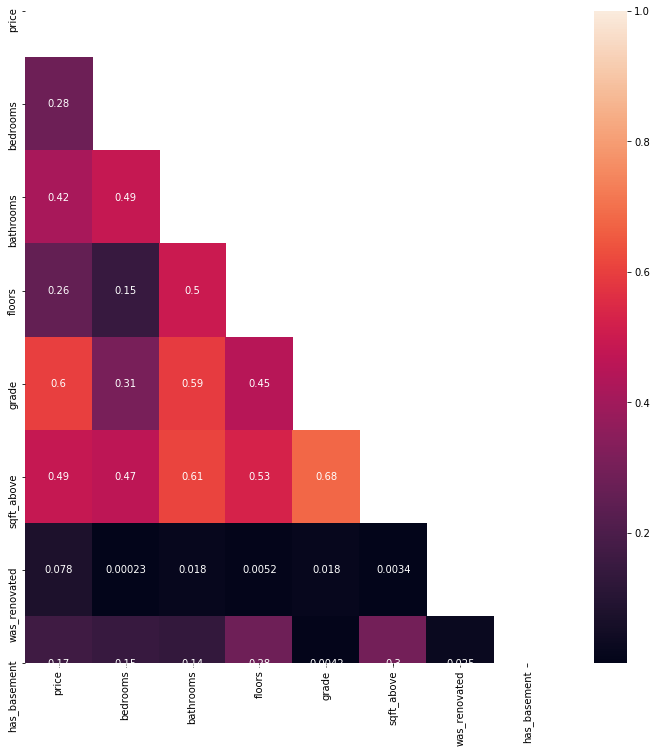

,price,bedrooms,bathrooms,floors,grade,sqft_above,was_renovated,has_basement
price,1.000,0.278,0.416,0.256,0.599,0.485,0.078,0.165
bedrooms,0.278,1.000,0.488,0.147,0.308,0.468,0.000,0.147
bathrooms,0.416,0.488,1.000,0.499,0.591,0.611,0.018,0.136
floors,0.256,0.147,0.499,1.000,0.451,0.530,0.005,0.282
grade,0.599,0.308,0.591,0.451,1.000,0.683,0.018,0.004
sqft_above,0.485,0.468,0.611,0.530,0.683,1.000,0.003,0.296
was_renovated,0.078,0.000,0.018,0.005,0.018,0.003,1.000,0.025
has_basement,0.165,0.147,0.136,0.282,0.004,0.296,0.025,1.000


In [111]:
df4_corr = multicol_plot(df4)

# 4. What features of a house yield make the house sell at a higher price?
As we can see from the above Coefficient Mapping tool we can see that renovation, condition, and grade had the highest impact on yielding a higher selling price.




### Improve the Grade of the House

1-3 - Falls short of minimum building standards. Normally cabin or inferior structure.

4 - Generally older, low quality construction. Does not meet code.

5 - Low construction costs and workmanship. Small, simple design.

6 - Lowest grade currently meeting building code. Low quality materials and simple designs.

7 - Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 - Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 - Better architectural design with extra interior and exterior design and quality.

10 - Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 - Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 - Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 - Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

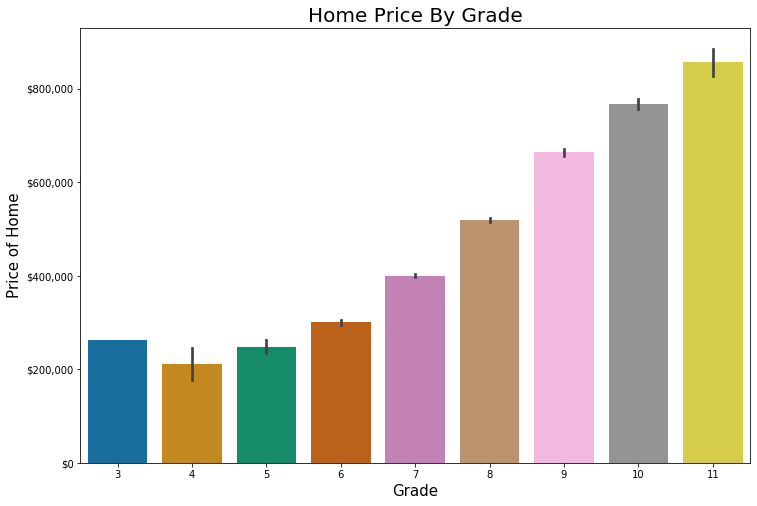

In [112]:
# Setting a figure size and plotting
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='grade', y='price', data=df4, palette="colorblind")

# Formatting the y-axis ticks to show as money
fmt_money = '${x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.yaxis.set_major_formatter(tick_money)

# Setting title and labels
ax.set_xlabel('Grade', fontsize=15)
ax.set_ylabel('Price of Home', fontsize=15)
ax.set_title('Home Price By Grade', fontsize=20);

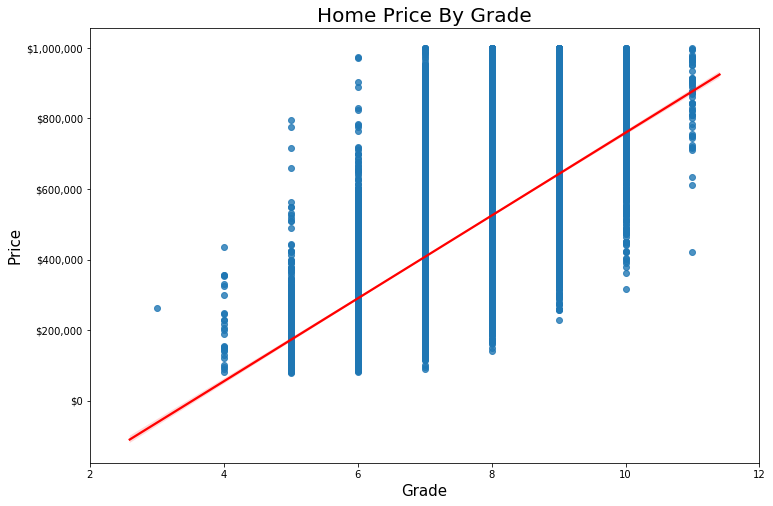

In [113]:
# Regplot

fig, ax = plt.subplots(figsize=(12,8))
sns.regplot(df4['grade'], df4['price'], line_kws={'color':'red'})
fmt_money = '${x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.yaxis.set_major_formatter(tick_money)
ax.set(xlim=(2, 12))
ax.set_xlabel('Grade', fontsize=15)
ax.set_ylabel('Price', fontsize=15)
ax.set_title('Home Price By Grade', fontsize=20);

### Increase the Number of Bedrooms

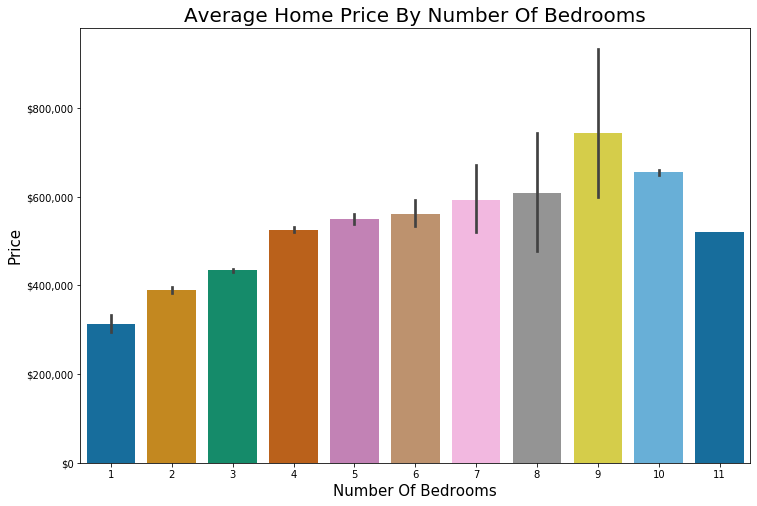

In [114]:
# Setting a figure size and plotting
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='bedrooms', y='price', data=df4, palette="colorblind")

# Formatting the y-axis ticks to show as money
fmt_money = '${x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.yaxis.set_major_formatter(tick_money)

# Setting title and labels
ax.set_xlabel('Number Of Bedrooms', fontsize=15)
ax.set_ylabel('Price', fontsize=15)
ax.set_title('Average Home Price By Number Of Bedrooms', fontsize=20);

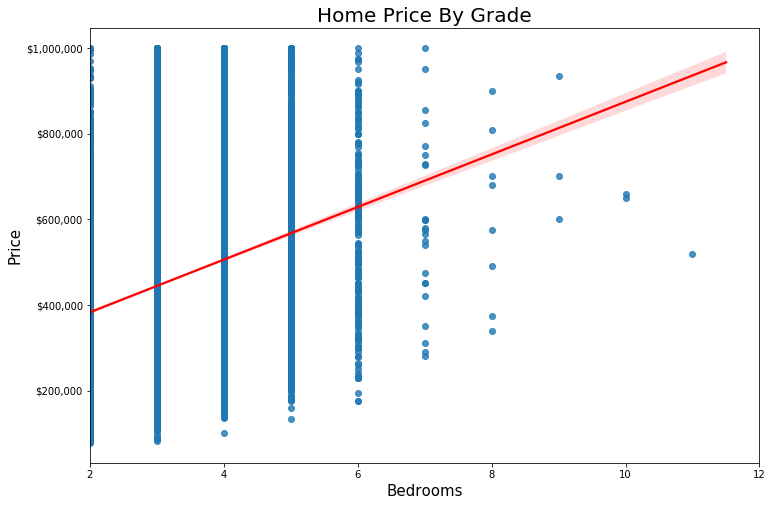

In [115]:
fig, ax = plt.subplots(figsize=(12,8))
sns.regplot(df4['bedrooms'], df4['price'], line_kws={'color':'red'})

# Formatting the y-axis ticks to show as money
fmt_money = '${x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.yaxis.set_major_formatter(tick_money)

# Setting the range of the x-ticks
ax.set(xlim=(2, 12))

# Setting title and labels
ax.set_xlabel('Bedrooms', fontsize=15)
ax.set_ylabel('Price', fontsize=15)
ax.set_title('Home Price By Grade', fontsize=20);

### Increase the Number of Bathrooms

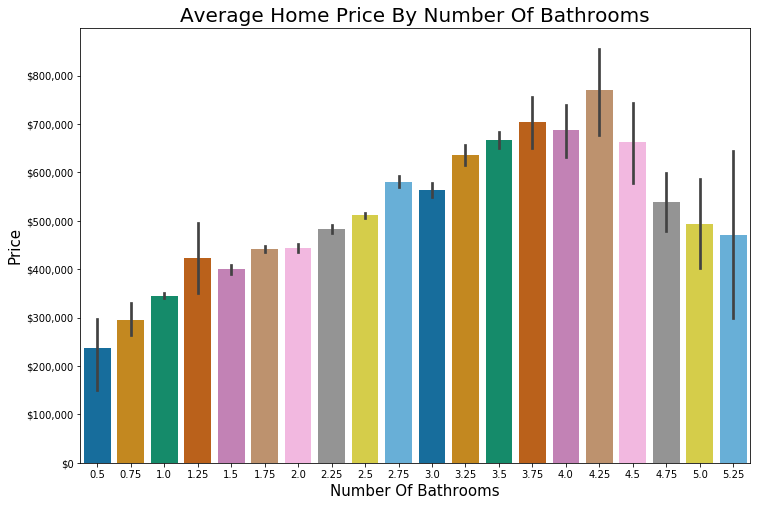

In [116]:
# Setting a figure size and plotting
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='bathrooms', y='price', data=df4, palette="colorblind")

# Formatting the y-axis ticks to show as money
fmt_money = '${x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.yaxis.set_major_formatter(tick_money)

# Setting title and labels
ax.set_xlabel('Number Of Bathrooms', fontsize=15)
ax.set_ylabel('Price', fontsize=15)
ax.set_title('Average Home Price By Number Of Bathrooms', fontsize=20);

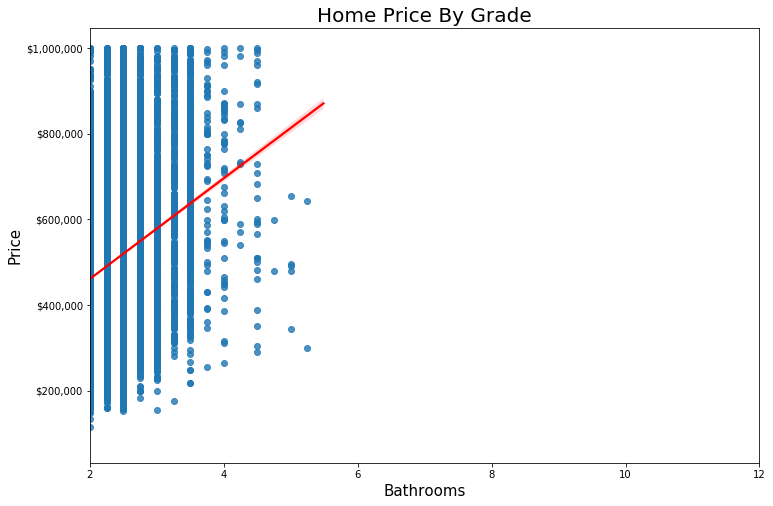

In [117]:
fig, ax = plt.subplots(figsize=(12,8))
sns.regplot(df4['bathrooms'], df4['price'], line_kws={'color':'red'})

# Formatting the y-axis ticks to show as money
fmt_money = '${x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.yaxis.set_major_formatter(tick_money)

# Setting the range of the x-ticks
ax.set(xlim=(2, 12))

# Setting title and labels
ax.set_xlabel('Bathrooms', fontsize=15)
ax.set_ylabel('Price', fontsize=15)
ax.set_title('Home Price By Grade', fontsize=20);

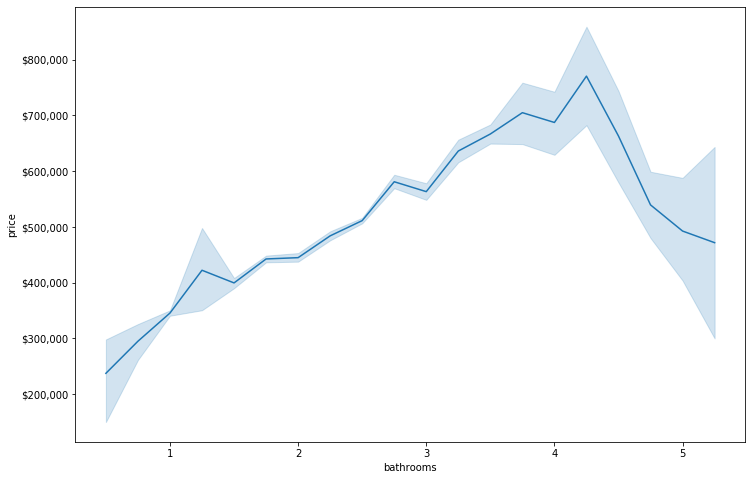

In [118]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(df4['bathrooms'], df4['price'])

# Formatting the y-axis ticks to show as money
fmt_money = '${x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.yaxis.set_major_formatter(tick_money)

### Square Footage of Upper Floors

In [119]:
df4.head()

,price,bedrooms,bathrooms,floors,condition,grade,sqft_above,was_renovated,seasons,has_basement
0,221900.000,3,1.000,1.000,3,7,1180,0,4,0
1,538000.000,3,2.250,2.000,3,7,2170,1,4,1
2,180000.000,2,1.000,1.000,3,6,770,0,1,0
3,604000.000,4,3.000,1.000,5,7,1050,0,4,1
4,510000.000,3,2.000,1.000,3,8,1680,0,1,0


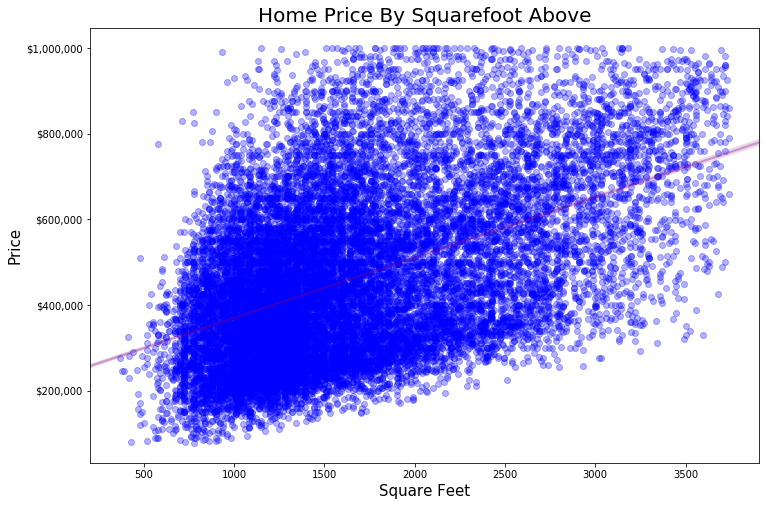

In [120]:
# Regplot for sqft

fig, ax = plt.subplots(figsize=(12,8))
sns.regplot(df4['sqft_above'], df4['price'], 
            scatter_kws = {'color': 'blue', 'alpha': 0.3}, 
            line_kws = {'color': 'purple', 'alpha': 0.3})

# Formatting the y-axis ticks to show as money
fmt_money = '${x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.yaxis.set_major_formatter(tick_money)

# Setting title and labels
ax.set_xlabel('Square Feet', fontsize=15)
ax.set_ylabel('Price', fontsize=15)
ax.set_title('Home Price By Squarefoot Above', fontsize=20);

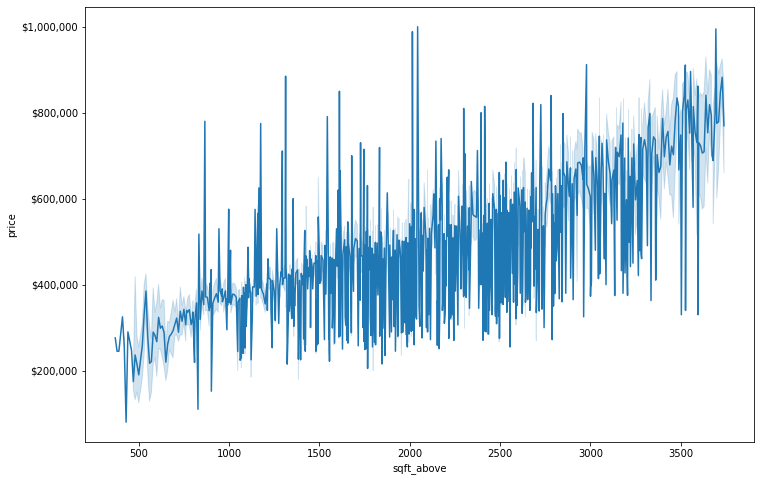

In [121]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(df4['sqft_above'], df4['price'])

# Formatting the y-axis ticks to show as money
fmt_money = '${x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.yaxis.set_major_formatter(tick_money)


Recommendations:
    

### Improve the Condition of the House

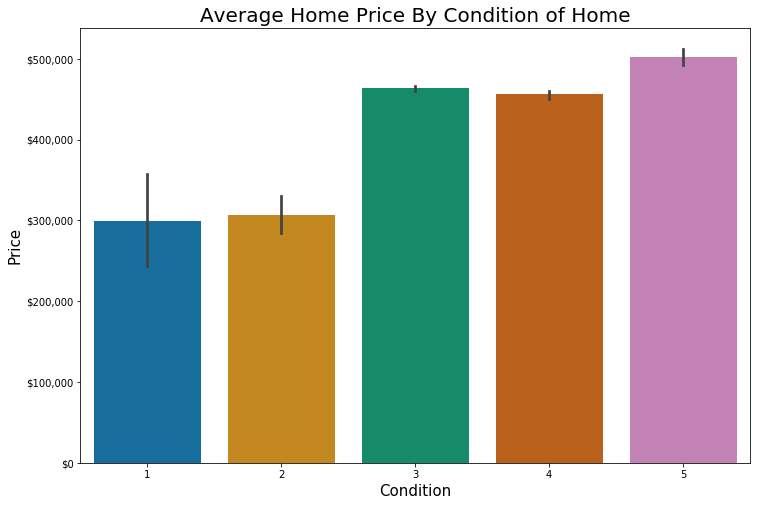

In [122]:
# Setting a figure size and plotting
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='condition', y='price', data=df4, palette="colorblind")

# Formatting the y-axis ticks to show as money
fmt_money = '${x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.yaxis.set_major_formatter(tick_money)

# Setting title and labels
ax.set_xlabel('Condition', fontsize=15)
ax.set_ylabel('Price', fontsize=15)
ax.set_title('Average Home Price By Condition of Home', fontsize=20);

### Add a Floor to the Home

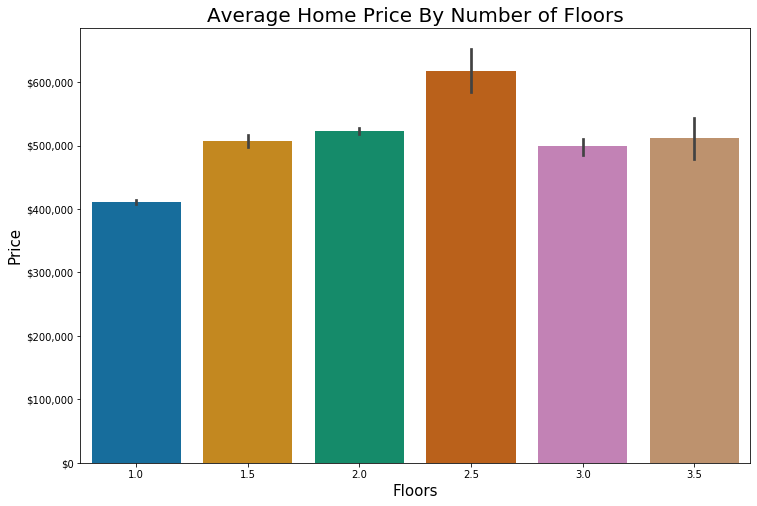

In [123]:
# Setting a figure size and plotting
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='floors', y='price', data=df4, palette="colorblind")

# Formatting the y-axis ticks to show as money
fmt_money = '${x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.yaxis.set_major_formatter(tick_money)

# Setting title and labels
ax.set_xlabel('Floors', fontsize=15)
ax.set_ylabel('Price', fontsize=15)
ax.set_title('Average Home Price By Number of Floors', fontsize=20);

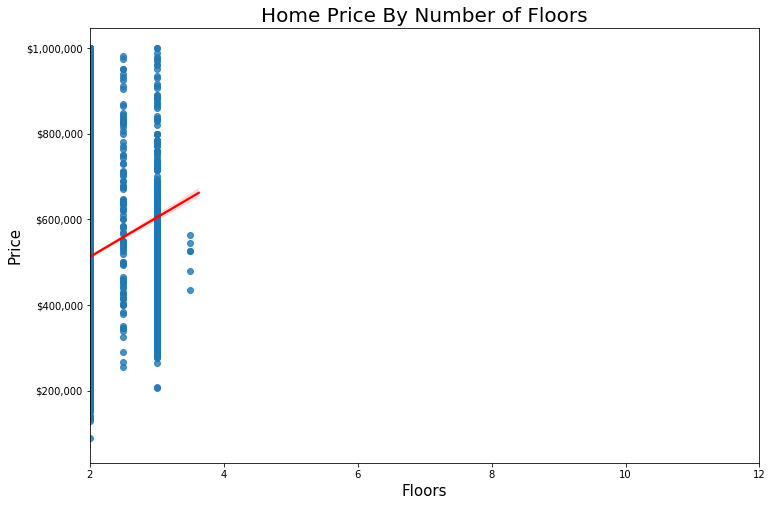

In [124]:
fig, ax = plt.subplots(figsize=(12,8))
sns.regplot(df4['floors'], df4['price'], line_kws={'color':'red'})

# Formatting the y-axis ticks to show as money
fmt_money = '${x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.yaxis.set_major_formatter(tick_money)

# Setting the range of the x-ticks
ax.set(xlim=(2, 12))

# Setting title and labels
ax.set_xlabel('Floors', fontsize=15)
ax.set_ylabel('Price', fontsize=15)
ax.set_title('Home Price By Number of Floors', fontsize=20);

# Tableau Map

# Future Work

1. With more time given, I would also like to utilize the latitude and longitude given in this dataset to make a Tableau map.
2. I would additionally experiment more with different outlier removals including Cooks Distance.
3. In closing, to improve the r2 score of this model that is currently low, I would better fit the model by checking for overfitting.